### Importing area

In [1]:
import civil_war_base as cw
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score

# Forecasting civil wars
Civil wars cost thousands of lives and force people to run away from their home countries. The Chadian Civil War of 2005 to 2010 costed about 7000 lives and 200000 refugees.  A powerful civil war forecast model can be useful both at anticipating conflict and to extract theory from the data. Early detection of conflict escalation, combined with intervention and mediation, can help avoid it by detecting key sectors and events. 

A python file called **"civil_war_base.py"** was created. It contains all the functions used in this notebook. For more information about the functions, please look them up in this file since they all contain docstrings with information. 

# 1. About the data

## 1.1. Integrated Crisis Early Warning System 
The Integrated Crisis Early Warning System ([ICEWS](https://en.wikipedia.org/wiki/Integrated_Conflict_Early_Warning_System))is a repository that contains counts of daily events worldwide. The data is currently stored in the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/28075) along with information about its content. This project uses version 29.0, with events from 1995 to April 2020. All the files are provided in the file **events.zip** in the same repository as this notebook. The file was uploaded using [Git Large File Storage](https://git-lfs.github.com/) due to its size. 

The ICEWS dataset records the "who did what to whom and where" for events across the globe. 

To simplify the description of data cleaning, the year 2017 is used in the following.

In [2]:
year_2017 = cw.read_events_year("events.zip",2017)
year_2017.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude
44956,25412353,1/29/2017,Rodrigo Duterte,"Executive,Executive Office,Government",Philippines,Threaten,130,-4.4,Armed Rebel (Philippines),"Rebel,Dissident",Philippines,43336684.0,1.0,Philippine Daily Inquirer,NaN,Cotabato City,Soccsksargen,Philippines,7.21667,124.2500
252430,27576818,5/11/2017,Jüri Ratas,"Government,Executive Office,Executive,Elite",Estonia,Make optimistic comment,13,0.4,Party Member (Estonia),Parties,Estonia,44235846.0,1.0,Baltic Daily,Jueri,Rae vald,Harjumaa,Estonia,NaN,24.8942
448177,27912081,8/11/2017,United Nations,"Global,International Government Organization,G...",NaN,Make an appeal or request,20,3.0,Other Authorities / Officials (Venezuela),Government,Venezuela,45040159.0,6.0,Unknown,Caracas,Municipio Libertador,Distrito Capital,Venezuela,NaN,-66.8792
213986,27509546,4/23/2017,Australia,NaN,Australia,"Arrest, detain, or charge with legal action",173,-5.0,Children (Australia),"General Population / Civilian / Social,Social",Australia,44075315.0,3.0,Unknown,Broken Hill,Broken Hill Municipality,State of New South Wales,Australia,-31.96170,NaN
363970,27768622,7/1/2017,Head of Government (Afghanistan),"Executive Office,Government,Executive",Afghanistan,Praise or endorse,51,3.4,Governor (Afghanistan),"Local,Government,Provincial",Afghanistan,44691374.0,4.0,BBC Monitoring South Asia,NaN,NaN,NaN,Afghanistan,NaN,69.1055


The table above shows some columns of the 2017 ICEWS dataset to see how it looks like. 

### 1.1.1. Conflict and Mediation Event Observations
The Conflict and Mediation Event Observations code (the *CAMEO Code* column) is a coding system for event data.  There are 20 different codes for 20 different types of events and each has different levels of subcoding. The document containing information about each code can be downloaded from the [Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/28075/SCJPXX&version=30.0) too. 

### 1.1.2. Intensity 
The intensity value (*Intensity* column) is obtained from the CAMEO code. It ranges from -10 to 10, with -10 representing the most hostile events and 10 the most cooperative events. 

### 1.1.3. Data preparation
- **1. Select events where "Source Country" is the same as "Target Country"**: To consider only internal events that may suggest internal conflict.

In [3]:
year_2017_internal = cw.internal_events_year("events.zip",2017)
year_2017_internal.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
319471,27691307,2017-06-09,Lawmaker (Philippines),"Government,Legislative / Parliamentary",Philippines,Complain officially,114,-2.0,Rodrigo Duterte,"Government,Executive Office,Executive",Philippines,44507004.0,3.0,Deutsche Welle,Davao,Davao City,Davao,Philippines,7.07306,NaN,2017-06
512766,28024131,2017-09-13,Militant (Egypt),Unidentified Forces,Egypt,Use unconventional violence,180,-9.0,Men (Egypt),"General Population / Civilian / Social,Social",Egypt,45312717.0,5.0,Xinhua News Agency,Giza,NaN,Muhafazat al Jizah,Egypt,30.00810,NaN,2017-09
204539,27492835,2017-04-18,Preneet Kaur,Government,India,Demand,100,-5.0,Government (India),Government,India,44035019.0,2.0,Hindustan Times,Sanaur,NaN,State of Punjab,India,30.30150,NaN,2017-04
550246,28093158,2017-10-03,Luiz Inacio Lula Da Silva,"Far Left,Elite,Parties,Ideological,(National) ...",Brazil,Criticize or denounce,111,-2.0,Government (Brazil),Government,Brazil,45480770.0,1.0,Agence France-Presse,Canada del Brasil,NaN,Departamento de Rio Negro,Uruguay,-33.03330,-57.1333,2017-10
328426,27706629,2017-06-13,Citizen (Australia),"Social,General Population / Civilian / Social",Australia,"Accuse of crime, corruption",1121,-2.0,Australia,NaN,Australia,44540967.0,1.0,Unknown,NaN,NaN,State of Queensland,Australia,-20.00000,NaN,2017-06


- **2. Simplify sectors mapping them**: Four sectors will be considered: Government (Gov), Insurgents (Ins), Opposition (Opp) and People (Peo). This will simplify the model and improve its interpretability. Cases where the source or the target were the country name were mapped as Government. 

In [4]:
year_2017_filtered = cw.read_filtered_data("events.zip",2017)
year_2017_filtered.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
644043,28250005,2017-11-17,Prime Minister bin Ibrahim,Opp,Malaysia,Praise or endorse,51,3.4,Mohammad Najib Abdul Razak,Gov,Malaysia,45855324.0,5.0,Unknown,Kuala Lumpur,NaN,Kuala Lumpur,Malaysia,NaN,101.6870,2017-11
140102,27377546,2017-03-19,Police (India),Gov,India,Consult,40,1.0,Director General (India),Gov,India,43763008.0,1.0,Hindustan Times,Lucknow,NaN,State of Uttar Pradesh,India,NaN,80.9231,2017-03
570597,28126267,2017-10-13,Cabinet / Council of Ministers / Advisors (India),Gov,India,Consult,40,1.0,Head of Government (India),Gov,India,45561912.0,2.0,The Times of India,Chennai,NaN,State of Tamil Nadu,India,NaN,80.2785,2017-10
641464,28245772,2017-11-16,Head of Government (Russia),Gov,Russian Federation,Make statement,10,0.0,Opposition Coalition (Russia),Opp,Russian Federation,45845479.0,2.0,BBC Monitoring Former Soviet Union,Parnas,NaN,Leningradskaya Oblast',Russian Federation,NaN,30.3487,2017-11
395747,27821872,2017-07-15,Party Member (India),NaN,India,Consult,40,1.0,Amit Shah,Gov,India,44809438.0,5.0,The Times of India,New Delhi,NaN,National Capital Territory of Delhi,India,NaN,NaN,2017-07


- **3. Remove irrelevant columns**: Only "Country", "Source Sectors" (renamed as "Source"), "CAMEO", "Intensity", "Target Sector" (renamed as "Target") and "Year_Month" will be considered. 

In [5]:
year_2017_cols = cw.read_cols_filtered("events.zip",2017)
year_2017_cols.sample(5)

,Country,Source,CAMEO,Intensity,Target,Year_Month
216546,India,Gov,173,-5.0,Peo,2017-04
593921,Australia,Gov,173,-5.0,Peo,2017-10
93803,India,Gov,173,-5.0,Peo,2017-02
147130,United Kingdom,Ins,182,-9.5,Gov,2017-03
621453,United Kingdom,Gov,100,-5.0,Peo,2017-11


**4. Dummy variables of interaction**: A column for each Source_Target interaction will be generated (Gov_Opp, Peo_Ins, Ins_Gov,...) containing 1 if the event happens between the source-target pair and 0 if not. 

In [6]:
year_2017_final = cw.source_target_interaction("events.zip",2017)
year_2017_final.sample(5)

,Country,CAMEO,Intensity,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
73947,Taiwan,160,-4.0,2017-02,0,0,1,0,0,0,0,0,0,0,0,0
285437,South Korea,173,-5.0,2017-05,0,0,1,0,0,0,0,0,0,0,0,0
405740,Israel,193,-10.0,2017-07,0,0,0,1,0,0,0,0,0,0,0,0
574478,Iraq,20,3.0,2017-10,0,0,1,0,0,0,0,0,0,0,0,0
340039,Australia,182,-9.5,2017-06,0,0,0,0,0,1,0,0,0,0,0,0


**5. Adding ISO3 country code**: To avoid double counting a country (for example, North Korea and Republic of Korea) the ISO3 country code will be added. 

In [7]:
year_2017_iso3 = cw.iso3country("events.zip",2017)
year_2017_iso3.sample(5)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
727069,Egypt,EGY,2017-12,10,0.0,1,0,0,0,0,0,0,0,0,0,0,0
364651,India,IND,2017-07,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
495186,Malaysia,MYS,2017-09,46,7.0,0,0,0,0,0,0,0,0,0,1,0,0
127240,Australia,AUS,2017-03,111,-2.0,0,1,0,0,0,0,0,0,0,0,0,0
507638,Canada,CAN,2017-09,112,-2.0,0,0,1,0,0,0,0,0,0,0,0,0


Only about 22% of the original events were kept after cleaning the data:

In [8]:
len(year_2017_iso3)/len(year_2017)

0.21782471296659203

The events for years from 1995 to 2018 were saved in an external file to avoid generating them all the time:

<code>all_events = cw.all_events("events.zip", 1995, 2018)
all_events.to_csv("all_events.csv")<\code>

In [9]:
all_events = pd.read_csv("all_events.csv", low_memory = False).drop("Unnamed: 0", axis = 1)
all_events["Year_Month"] = pd.to_datetime(all_events["Year_Month"])

In [10]:
all_events.sample(5)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
2646227,India,IND,2015-06-01,020,3.0,0,0,0,0,0,0,0,0,0,1,0,0
2624502,India,IND,2015-05-01,030,4.0,0,0,1,0,0,0,0,0,0,0,0,0
1821445,Sweden,SWE,2010-10-01,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
964122,Venezuela,VEN,2005-12-01,160,-4.0,0,0,0,0,0,0,0,0,0,0,0,1
1798774,Argentina,ARG,2010-08-01,111,-2.0,0,0,1,0,0,0,0,0,0,0,0,0


The distribution of registered events per month can be seen bellow:

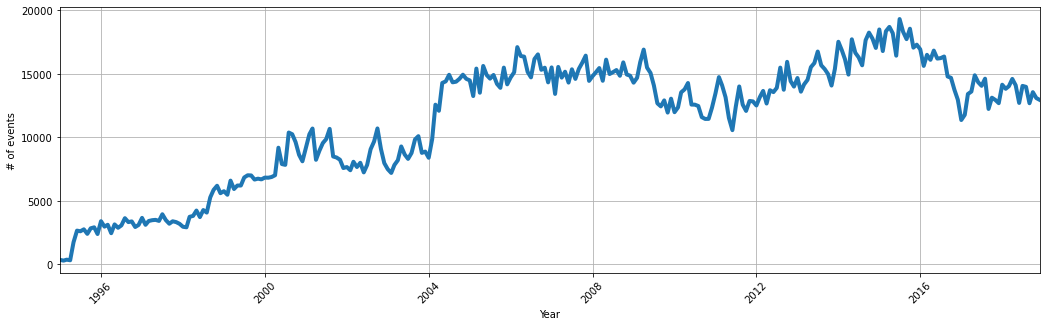

In [11]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(all_events["Year_Month"].value_counts().sort_index(), linewidth=4)
ax.grid()
plt.xticks(rotation=45);
ax.autoscale(enable=True, axis="x", tight=True)
ax.set_ylabel("# of events")
ax.set_xlabel("Year")
plt.rcParams.update({"font.size": 22})
plt.tight_layout()

The number of events registered is not consistent, suggesting that from 1995 until 2004 data collection was performed differently. However, the distribution of events does not show any outliers:

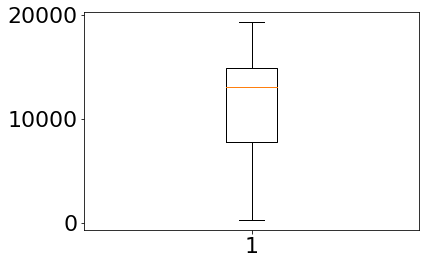

In [12]:
plt.boxplot(all_events["Year_Month"].value_counts());

Due to the absence of outliers, all events will be used in the model. 

# 1.2. Political Instability Task Force
The State Failure Problem dataset will be used to stablish the start and ending of a civil war. This dataset comes from the Political Instability Task Force ([PITF](https://en.wikipedia.org/wiki/Political_Instability_Task_Force)), which is an American project that focuses on collecting data of political conflicts and state failure. The dataset can be found on the Center of Systemic Peace [webiste](http://www.systemicpeace.org/inscrdata.html) as the [Cosolidated Cases](http://www.systemicpeace.org/inscr/PITF%20Consolidated%20Case%20List%202018.pdf) dataset. The PITF criteria to determine a civil war can be found in its [Codebook](http://www.systemicpeace.org/inscr/PITFProbSetCodebook2018.pdf). This dataset containg civil wars from 1955 to 2018. 

## 1.2.1. Cleaning the data
The original data is presented in a PDF an was converted to a **.xlsx** using a [PDF to Excel Converter](https://smallpdf.com/pdf-to-excel). The returned file contains errors. A function that reads and fixes the data was defined <code>read_PITF()</code>:

In [13]:
PITF = cw.read_PITF("PITF Consolidated Case List 2018-converted.xlsx")
PITF.sample(5)

,ISO3,Year_Month_S,Year_Month_F
18,MMR,1948-03,2018-12
15,BIH,1992-04,1995-12
142,LKA,1983-07,2009-05
150,TJK,1992-04,1998-12
154,TUR,1980-09,2018-12


## 2. CAMEO counts model
The CAMEO code contain 20 codes, each one with their sublevels of coding. For example "10" is "Demand" but "1043" is "Demand rights". The 20 main CAMEO codes are:
- 01: Make public statement
- 02: Appeal
- 03: Express intent to cooperate
- 04: Consult
- 05: Engage in diplomatic cooperation
- 06: Engage in material cooperation
- 07: Provide aid
- 08: Yield
- 09: Investigate
- 10: Demand
- 11: Disapprove
- 12: Reject
- 13: Threaten
- 14: Protest
- 15: Exhibit force posture
- 16: Reduce relatins
- 17: Coerce
- 18: Assault
- 19: Fight
- 20: Use unconventional mass violence

The model will use only the first two number of the code, so that it sticks to the main CAMEO codes. Then, dummy variables for Source-Target-Cameo triad will be generated. There will be 240 predictors:

In [14]:
all_events["Year_Month"] = all_events["Year_Month"].dt.to_period("M")

In [15]:
# Generating model
cameo_counts = all_events[["ISO3","Year_Month","Intensity"]]

In [16]:
# Selecting just the first two numbers of the CAMEO code
cameo_counts["CAMEO"] = all_events["CAMEO"].apply(lambda x: x[:2])

In [17]:
# Getting values in the right column
cols = all_events.columns[5:]
for col in cols:
    cameo_counts[col] = all_events[col]*cameo_counts["CAMEO"]
    cameo_counts[col] = cameo_counts[col].apply(cw.cleaning_cameo) # Custom function

In [18]:
# Filling missing values
cameo_counts = cameo_counts.fillna(0)

In [19]:
# Adding dummy variables
cameo_counts = cameo_counts.drop(["CAMEO"], axis=1)
cameo = ["01","02","03","04","05","06","07","08","09","10",
         "11","12","13","14","15","16","17","18","19","20"]
for col in cols:
    for code in cameo:
        col_name = col+'_'+code
        cameo_counts[col_name] = (cameo_counts[col] == code).astype("int64")

In [20]:
# Removing irrelevant columns
cameo_counts = cameo_counts.drop(cols, axis = 1)

In [21]:
# Aggregating
cameo_counts = cameo_counts.groupby(["ISO3","Year_Month"]).sum().reset_index()

Finally, it is necessary to add the predictor in the model. It is shifted one month up, so that, for example, 2016-07 contains what happened in 2016-08. Different classes are assigned:
- "P": Period of peace
- "S": A civil war starts
- "O": A civil war is ongoing
- "E": A civil war ends

In [22]:
cameo_counts = cw.add_missing_months(cameo_counts)
cameo_counts = cw.add_cw(cameo_counts, "PITF Consolidated Case List 2018-converted.xlsx")

In [23]:
cameo_counts.sample(5)

,ISO3,Year_Month,Intensity,Gov_Ins_01,Gov_Ins_02,Gov_Ins_03,Gov_Ins_04,Gov_Ins_05,Gov_Ins_06,Gov_Ins_07,Gov_Ins_08,Gov_Ins_09,Gov_Ins_10,Gov_Ins_11,Gov_Ins_12,Gov_Ins_13,Gov_Ins_14,Gov_Ins_15,Gov_Ins_16,Gov_Ins_17,Gov_Ins_18,Gov_Ins_19,Gov_Ins_20,Gov_Opp_01,Gov_Opp_02,Gov_Opp_03,Gov_Opp_04,Gov_Opp_05,Gov_Opp_06,Gov_Opp_07,Gov_Opp_08,Gov_Opp_09,Gov_Opp_10,Gov_Opp_11,Gov_Opp_12,Gov_Opp_13,Gov_Opp_14,Gov_Opp_15,Gov_Opp_16,Gov_Opp_17,Gov_Opp_18,Gov_Opp_19,Gov_Opp_20,Gov_Peo_01,Gov_Peo_02,Gov_Peo_03,Gov_Peo_04,Gov_Peo_05,Gov_Peo_06,Gov_Peo_07,Gov_Peo_08,Gov_Peo_09,Gov_Peo_10,Gov_Peo_11,Gov_Peo_12,Gov_Peo_13,Gov_Peo_14,Gov_Peo_15,Gov_Peo_16,Gov_Peo_17,Gov_Peo_18,Gov_Peo_19,Gov_Peo_20,Ins_Gov_01,Ins_Gov_02,Ins_Gov_03,Ins_Gov_04,Ins_Gov_05,Ins_Gov_06,Ins_Gov_07,Ins_Gov_08,Ins_Gov_09,Ins_Gov_10,Ins_Gov_11,Ins_Gov_12,Ins_Gov_13,Ins_Gov_14,Ins_Gov_15,Ins_Gov_16,Ins_Gov_17,Ins_Gov_18,Ins_Gov_19,Ins_Gov_20,Ins_Opp_01,Ins_Opp_02,Ins_Opp_03,Ins_Opp_04,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_08,Ins_Opp_09,Ins_Opp_10,Ins_Opp_11,Ins_Opp_12,Ins_Opp_13,Ins_Opp_14,Ins_Opp_15,Ins_Opp_16,Ins_Opp_17,Ins_Opp_18,Ins_Opp_19,Ins_Opp_20,Ins_Peo_01,Ins_Peo_02,Ins_Peo_03,Ins_Peo_04,Ins_Peo_05,Ins_Peo_06,Ins_Peo_07,Ins_Peo_08,Ins_Peo_09,Ins_Peo_10,Ins_Peo_11,Ins_Peo_12,Ins_Peo_13,Ins_Peo_14,Ins_Peo_15,Ins_Peo_16,Ins_Peo_17,Ins_Peo_18,Ins_Peo_19,Ins_Peo_20,Opp_Gov_01,Opp_Gov_02,Opp_Gov_03,Opp_Gov_04,Opp_Gov_05,Opp_Gov_06,Opp_Gov_07,Opp_Gov_08,Opp_Gov_09,Opp_Gov_10,Opp_Gov_11,Opp_Gov_12,Opp_Gov_13,Opp_Gov_14,Opp_Gov_15,Opp_Gov_16,Opp_Gov_17,Opp_Gov_18,Opp_Gov_19,Opp_Gov_20,Opp_Ins_01,Opp_Ins_02,Opp_Ins_03,Opp_Ins_04,Opp_Ins_05,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Ins_10,Opp_Ins_11,Opp_Ins_12,Opp_Ins_13,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_18,Opp_Ins_19,Opp_Ins_20,Opp_Peo_01,Opp_Peo_02,Opp_Peo_03,Opp_Peo_04,Opp_Peo_05,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Opp_Peo_09,Opp_Peo_10,Opp_Peo_11,Opp_Peo_12,Opp_Peo_13,Opp_Peo_14,Opp_Peo_15,Opp_Peo_16,Opp_Peo_17,Opp_Peo_18,Opp_Peo_19,Opp_Peo_20,Peo_Gov_01,Peo_Gov_02,Peo_Gov_03,Peo_Gov_04,Peo_Gov_05,Peo_Gov_06,Peo_Gov_07,Peo_Gov_08,Peo_Gov_09,Peo_Gov_10,Peo_Gov_11,Peo_Gov_12,Peo_Gov_13,Peo_Gov_14,Peo_Gov_15,Peo_Gov_16,Peo_Gov_17,Peo_Gov_18,Peo_Gov_19,Peo_Gov_20,Peo_Ins_01,Peo_Ins_02,Peo_Ins_03,Peo_Ins_04,Peo_Ins_05,Peo_Ins_06,Peo_Ins_07,Peo_Ins_08,Peo_Ins_09,Peo_Ins_10,Peo_Ins_11,Peo_Ins_12,Peo_Ins_13,Peo_Ins_14,Peo_Ins_15,Peo_Ins_16,Peo_Ins_17,Peo_Ins_18,Peo_Ins_19,Peo_Ins_20,Peo_Opp_01,Peo_Opp_02,Peo_Opp_03,Peo_Opp_04,Peo_Opp_05,Peo_Opp_06,Peo_Opp_07,Peo_Opp_08,Peo_Opp_09,Peo_Opp_10,Peo_Opp_11,Peo_Opp_12,Peo_Opp_13,Peo_Opp_14,Peo_Opp_15,Peo_Opp_16,Peo_Opp_17,Peo_Opp_18,Peo_Opp_19,Peo_Opp_20,CW_plus1
30953,NPL,2017-01,-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P
30343,NLD,2011-05,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

The table above shows the structure of the "CAMEO counts" model. 

### 2.1. Predictor importance and theory
Predictor importance derived from t-tests is not only relevant to training the model but also to give a theoretical approach to civil war forecasting. 

A good way to determine conflict escalation is to compare the distributions of Intensity for each case:

In [24]:
cases = ["P", "S", "O", "E"]
plots = []
for case in cases:
    plots.append(cameo_counts[cameo_counts["CW_plus1"]==case]["Intensity"])

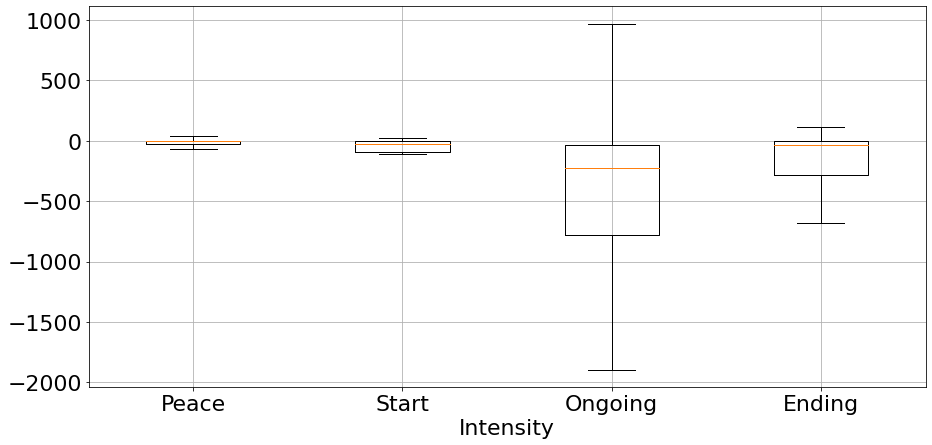

In [25]:
f, ax = plt.subplots(figsize = (15,7))
ax.boxplot(plots, showfliers=False);
ax.set_xlabel("Intensity")
ax.set_xticklabels(["Peace", "Start", "Ongoing", "Ending"])
ax.grid()

Escalation and relaxation of the conflict can be seen in the distributions of intensity. It decreases from periods of peace up to the ongoingness of the conflict and at the end it increases. 

#### 2.1.1 Periods of peace and the start of a civil war
Each monthly aggregatin where a civil war starts will be marked with a 1, 0 otherwise. 

In [26]:
cameo_counts_ps = cameo_counts[(cameo_counts["CW_plus1"]=="S") | (cameo_counts["CW_plus1"]=="P")]
cameo_counts_ps["CW_plus1"] = (cameo_counts_ps["CW_plus1"] == "S").astype("int64")

As a first approach, the differences in means for each case are:

In [27]:
cols = cameo_counts_ps.columns[2:-1]
mean_values = pd.DataFrame(index = [0,1], columns = cols)
mean_values.loc[0,:] = cameo_counts_ps[cameo_counts_ps["CW_plus1"]==0][cols].mean().round(4)
mean_values.loc[1,:] = cameo_counts_ps[cameo_counts_ps["CW_plus1"]==1][cols].mean().round(4)
mean_values

,Intensity,Gov_Ins_01,Gov_Ins_02,Gov_Ins_03,Gov_Ins_04,Gov_Ins_05,Gov_Ins_06,Gov_Ins_07,Gov_Ins_08,Gov_Ins_09,Gov_Ins_10,Gov_Ins_11,Gov_Ins_12,Gov_Ins_13,Gov_Ins_14,Gov_Ins_15,Gov_Ins_16,Gov_Ins_17,Gov_Ins_18,Gov_Ins_19,Gov_Ins_20,Gov_Opp_01,Gov_Opp_02,Gov_Opp_03,Gov_Opp_04,Gov_Opp_05,Gov_Opp_06,Gov_Opp_07,Gov_Opp_08,Gov_Opp_09,Gov_Opp_10,Gov_Opp_11,Gov_Opp_12,Gov_Opp_13,Gov_Opp_14,Gov_Opp_15,Gov_Opp_16,Gov_Opp_17,Gov_Opp_18,Gov_Opp_19,Gov_Opp_20,Gov_Peo_01,Gov_Peo_02,Gov_Peo_03,Gov_Peo_04,Gov_Peo_05,Gov_Peo_06,Gov_Peo_07,Gov_Peo_08,Gov_Peo_09,Gov_Peo_10,Gov_Peo_11,Gov_Peo_12,Gov_Peo_13,Gov_Peo_14,Gov_Peo_15,Gov_Peo_16,Gov_Peo_17,Gov_Peo_18,Gov_Peo_19,Gov_Peo_20,Ins_Gov_01,Ins_Gov_02,Ins_Gov_03,Ins_Gov_04,Ins_Gov_05,Ins_Gov_06,Ins_Gov_07,Ins_Gov_08,Ins_Gov_09,Ins_Gov_10,Ins_Gov_11,Ins_Gov_12,Ins_Gov_13,Ins_Gov_14,Ins_Gov_15,Ins_Gov_16,Ins_Gov_17,Ins_Gov_18,Ins_Gov_19,Ins_Gov_20,Ins_Opp_01,Ins_Opp_02,Ins_Opp_03,Ins_Opp_04,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_08,Ins_Opp_09,Ins_Opp_10,Ins_Opp_11,Ins_Opp_12,Ins_Opp_13,Ins_Opp_14,Ins_Opp_15,Ins_Opp_16,Ins_Opp_17,Ins_Opp_18,Ins_Opp_19,Ins_Opp_20,Ins_Peo_01,Ins_Peo_02,Ins_Peo_03,Ins_Peo_04,Ins_Peo_05,Ins_Peo_06,Ins_Peo_07,Ins_Peo_08,Ins_Peo_09,Ins_Peo_10,Ins_Peo_11,Ins_Peo_12,Ins_Peo_13,Ins_Peo_14,Ins_Peo_15,Ins_Peo_16,Ins_Peo_17,Ins_Peo_18,Ins_Peo_19,Ins_Peo_20,Opp_Gov_01,Opp_Gov_02,Opp_Gov_03,Opp_Gov_04,Opp_Gov_05,Opp_Gov_06,Opp_Gov_07,Opp_Gov_08,Opp_Gov_09,Opp_Gov_10,Opp_Gov_11,Opp_Gov_12,Opp_Gov_13,Opp_Gov_14,Opp_Gov_15,Opp_Gov_16,Opp_Gov_17,Opp_Gov_18,Opp_Gov_19,Opp_Gov_20,Opp_Ins_01,Opp_Ins_02,Opp_Ins_03,Opp_Ins_04,Opp_Ins_05,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Ins_10,Opp_Ins_11,Opp_Ins_12,Opp_Ins_13,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_18,Opp_Ins_19,Opp_Ins_20,Opp_Peo_01,Opp_Peo_02,Opp_Peo_03,Opp_Peo_04,Opp_Peo_05,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Opp_Peo_09,Opp_Peo_10,Opp_Peo_11,Opp_Peo_12,Opp_Peo_13,Opp_Peo_14,Opp_Peo_15,Opp_Peo_16,Opp_Peo_17,Opp_Peo_18,Opp_Peo_19,Opp_Peo_20,Peo_Gov_01,Peo_Gov_02,Peo_Gov_03,Peo_Gov_04,Peo_Gov_05,Peo_Gov_06,Peo_Gov_07,Peo_Gov_08,Peo_Gov_09,Peo_Gov_10,Peo_Gov_11,Peo_Gov_12,Peo_Gov_13,Peo_Gov_14,Peo_Gov_15,Peo_Gov_16,Peo_Gov_17,Peo_Gov_18,Peo_Gov_19,Peo_Gov_20,Peo_Ins_01,Peo_Ins_02,Peo_Ins_03,Peo_Ins_04,Peo_Ins_05,Peo_Ins_06,Peo_Ins_07,Peo_Ins_08,Peo_Ins_09,Peo_Ins_10,Peo_Ins_11,Peo_Ins_12,Peo_Ins_13,Peo_Ins_14,Peo_Ins_15,Peo_Ins_16,Peo_Ins_17,Peo_Ins_18,Peo_Ins_19,Peo_Ins_20,Peo_Opp_01,Peo_Opp_02,Peo_Opp_03,Peo_Opp_04,Peo_Opp_05,Peo_Opp_06,Peo_Opp_07,Peo_Opp_08,Peo_Opp_09,Peo_Opp_10,Peo_Opp_11,Peo_Opp_12,Peo_Opp_13,Peo_Opp_14,Peo_Opp_15,Peo_Opp_16,Peo_Opp_17,Peo_Opp_18,Peo_Opp_19,Peo_Opp_20
0,-51.7253,0.4283,0.0223,0.0362,0.0653,0.0328,0.0031,0.0016,0.0472,0.0836,0.0295,0.0726,0.0234,0.0134,0.0006,0.0021,0.0039,0.6608,0.012,0.1998,0.0004,0.2085,0.0491,0.0465,0.0655,0.0454,0.0021,0.0016,0.0289,0.0116,0.0198,0.088,0.0342,0.007,0.002,0.0002,0.0068,0.276,0.0216,0.0946,0.0017,1.4491,1.3123,0.7241,0.4714,0.3169,0.0349,0.1929,0.3065,0.6012,0.3641,0.8758,0.2986,0.1077,0.0031,0.0019,0.0484,3.7785,0.1827,0.7748,0.0512,0.1009,0.0191,0.0331,0.066,0.02,0.002,0.0026,0.0144,0.0031,0.0135,0.0464,0.0122,0.0282,0.0084,0.0014,0.0044,0.0026,0.2246,0.1046,0.0005,0.0017,0.0003,0.0003,0.0012,0.001,0.0001,0.0001,0.0003,0.0001,0.0001,0.0006,0.0001,0.0002,0,0,0.0001,0.0001,0.003,0.0009,0,0.0154,0.0184,0.0091,0.0076,0.0019,0.0002,0.0008,0.0191,0.0033,0.0206,0.0193,0.004,0.0437,0.0005,0,0.0013,0.0066,0.4747,0.1085,0.0021,0.1557,0.0794,0.0385,0.0653,0.0408,0.0023,0.0011,0.0036,0.0046,0.045,0.1654,0.0264,0.0151,0.5606,0.0001,0.0082,0.0007,0.0402,0.0077,0.0029,0.0043,0.0008,0.0004,0.0012,0.0009,0.0001,0,0.0001,0.0001,0.0003,0.001,0.0001,0.0001,0.0016,0,0.0001,0,0.005,0.0001,0,0.019,0.0324,0.0086,0.0057,0.0058,0.0005,0.0006,0.0016,0.0017,0.0085,0.025,0.004,0.0038,0.0089,0,0.0013,0.001,0.0324,0.0034,0.0013,1.952,0.833,0.7301,0.4717,0.183,0.0326,0.03,0.0668,0.0603,0.3148,1.1409,0.1868,0.1516,0.3528,0.0047,0.0438,0.0468,0.5767,0.1622,0.0292,0.1185,

Some differences are already observable in the means. 

For starting civil wars some means are 0, idicating that events with that triads did not occur at the start of a civil war. For example, "*Gov_Ins_03*", "*Gov_Ins_06*" or "*Gov_Ins_07*". These three columns have the Government as source and the Insurgents as targets. CAMEO codes 03 (Express intent to cooperate), 06 (Engage in material cooperation) and 07 (Provide aid) reflect that at the beginning of a civil war, these actions tend to not happen. This are positive actions, meaning that they are cooperative and should have a positive intensity, which explains why the Intensity has a lower value at the beginning of a civil war. 

In [28]:
np.sum(mean_values.loc[1,:]==0)

99

Out of 240 predictors, 99 have 0 registered events at the beginning of a civil war. These are the predictors:

In [29]:
mean_values.loc[:,mean_values.loc[1,:] == 0].sort_values(0, ascending = False, axis = 1)

,Peo_Gov_09,Gov_Ins_03,Ins_Gov_02,Ins_Peo_01,Ins_Gov_10,Peo_Ins_02,Gov_Opp_09,Peo_Ins_10,Ins_Gov_14,Peo_Opp_03,Peo_Ins_04,Ins_Peo_04,Peo_Ins_12,Gov_Opp_16,Peo_Ins_08,Peo_Ins_13,Opp_Ins_18,Peo_Gov_15,Opp_Gov_09,Ins_Gov_16,Gov_Ins_16,Peo_Ins_14,Opp_Peo_13,Ins_Peo_09,Peo_Ins_05,Ins_Gov_09,Gov_Peo_14,Gov_Ins_06,Opp_Gov_20,Peo_Opp_14,Peo_Opp_17,Ins_Peo_20,Gov_Ins_15,Gov_Opp_06,Gov_Opp_14,Ins_Gov_06,Gov_Peo_15,Ins_Peo_05,Peo_Opp_13,Peo_Opp_16,Ins_Opp_01,Opp_Peo_09,Gov_Ins_07,Opp_Ins_14,Ins_Gov_15,Opp_Peo_16,Ins_Peo_16,Peo_Opp_09,Peo_Ins_16,Opp_Gov_07,Opp_Peo_17,Opp_Ins_11,Opp_Ins_05,Opp_Ins_02,Ins_Peo_07,Opp_Gov_17,Gov_Ins_14,Peo_Opp_07,Ins_Opp_11,Opp_Peo_07,Ins_Peo_14,Ins_Gov_20,Opp_Peo_06,Peo_Ins_20,Peo_Ins_07,Peo_Opp_20,Gov_Ins_20,Ins_Opp_02,Opp_Ins_10,Ins_Opp_08,Gov_Opp_15,Ins_Peo_06,Peo_Ins_06,Ins_Opp_13,Ins_Opp_16,Opp_Ins_19,Ins_Opp_06,Ins_Opp_07,Peo_Opp_06,Ins_Opp_09,Ins_Opp_10,Ins_Opp_12,Opp_Gov_15,Ins_Opp_17,Opp_Ins_06,Opp_Ins_08,Opp_Ins_09,Opp_Ins_16,Ins_Opp_15,Ins_Opp_14,Peo_Ins_15,Ins_Opp_20,Ins_Peo_15,Opp_Ins_07,Opp_Peo_15,Opp_Ins_15,Peo_Opp_15,Opp_Ins_17,Opp_Ins_20
0,0.0603,0.0362,0.0191,0.0154,0.0135,0.0122,0.0116,0.011,0.0084,0.0082,0.0076,0.0076,0.007,0.0068,0.0063,0.0058,0.005,0.0047,0.0046,0.0044,0.0039,0.0038,0.0038,0.0033,0.0032,0.0031,0.0031,0.0031,0.0029,0.0026,0.0024,0.0021,0.0021,0.0021,0.002,0.002,0.0019,0.0019,0.0018,0.0017,0.0017,0.0017,0.0016,0.0016,0.0014,0.0013,0.0013,0.0012,0.0012,0.0011,0.001,0.001,0.0009,0.0008,0.0008,0.0007,0.0006,0.0006,0.0006,0.0006,0.0005,0.0005,0.0005,0.0004,0.0004,0.0004,0.0004,0.0003,0.0003,0.0003,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The predictors are sorted by the mean for periods of peace. Some of the means are very low, so that the differences are not really significant. So all means bellow 0.01 for periods of peace can be left out. The final predictors are:

In [30]:
list_of_index1 = [index for index in mean_values.loc[1,:].index if ((mean_values.loc[1,index] == 0) \
                                                                    & (mean_values.loc[0,index]>=0.01))]
mean_values.loc[:,list_of_index1]

,Gov_Ins_03,Gov_Opp_09,Ins_Gov_02,Ins_Gov_10,Ins_Peo_01,Peo_Gov_09,Peo_Ins_02,Peo_Ins_10
0,0.0362,0.0116,0.0191,0.0135,0.0154,0.0603,0.0122,0.011
1,0,0,0,0,0,0,0,0


Some useful information regarding the behaviour of the government can be extracted from these values: 
- *Gov_Ins_03*: The Government did not express intent to cooperate with Insurgents. Suggesting the friction between the sectors.
- *Ins_Gov_02*, *Ins_Gov_10*: Appeals and demands from Insurgents to the Government did not occur. This also reflects the lack of negotiation between the sectors. 

All this information satisfies the requirement that the model must be able to explain and detect key factors that start conflict. These, however, are just the CAMEO codes that have not occured at the beggining of a civil war, between certain sectors, and in the dataset, which does not mean they can not happen at the beginning of a civil war. 

The same thing happens during periods of peace:

In [31]:
np.sum(mean_values.loc[0,:]==0)

11

11 predictors did not record any event during periods of peace. These are:

In [32]:
list_of_index2 = [index for index in mean_values.loc[0,:].index if (mean_values.loc[0,index] == 0)]
mean_values.loc[:,list_of_index2]

,Ins_Opp_14,Ins_Opp_15,Ins_Opp_20,Ins_Peo_15,Opp_Ins_07,Opp_Ins_15,Opp_Ins_17,Opp_Ins_20,Opp_Peo_15,Peo_Ins_15,Peo_Opp_15
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0


These are columns that did not register any events during periods of peace nor at the start of a civil war. So these are irrelevant predictors. Most of them contain the CAMEO code 15 which stands for "*Exhibit force posture*", which is something that usually the government does. 

For the rest of predictors, the t-tests are evaluated bellow. Situations where there are no events registered will be left out, focusing only in differences between means where events occured:

In [33]:
pvalues = []
for i in range(0, len(cols)):
    if cols[i] in [index for index in mean_values.loc[1,:].index if (mean_values.loc[1,index] == 0)]:
        pass
    elif cols[i] in [index for index in mean_values.loc[0,:].index if (mean_values.loc[0,index] == 0)]:
        pass
    else:
        a = cameo_counts_ps[cameo_counts_ps["CW_plus1"]==0][cols[i]]
        b = cameo_counts_ps[cameo_counts_ps["CW_plus1"]==1][cols[i]]
        pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
        pvalues.append((cols[i], pvalue))
pd.DataFrame(pvalues).set_index(0).sort_values(1).round(3).transpose()

,Gov_Peo_19,Ins_Gov_18,Gov_Ins_19,Opp_Gov_01,Gov_Peo_18,Opp_Gov_11,Peo_Gov_18,Peo_Gov_11,Peo_Gov_10,Gov_Peo_08,Peo_Gov_14,Gov_Peo_02,Intensity,Ins_Gov_19,Ins_Gov_01,Peo_Opp_05,Opp_Gov_16,Peo_Gov_03,Peo_Gov_08,Gov_Peo_01,Peo_Gov_13,Gov_Peo_11,Gov_Peo_07,Opp_Gov_02,Gov_Ins_17,Peo_Opp_01,Gov_Ins_02,Ins_Peo_18,Gov_Peo_04,Peo_Gov_04,Opp_Peo_02,Peo_Gov_05,Opp_Gov_19,Gov_Peo_10,Gov_Peo_17,Gov_Ins_01,Gov_Peo_12,Gov_Opp_01,Gov_Peo_05,Peo_Gov_07,Opp_Gov_12,Gov_Ins_11,Peo_Opp_11,Gov_Opp_19,Ins_Peo_19,Ins_Opp_05,Peo_Gov_01,Opp_Peo_11,Gov_Opp_20,Gov_Opp_11,Ins_Gov_17,Ins_Peo_11,Opp_Gov_03,Gov_Opp_07,Ins_Gov_11,Gov_Ins_05,Opp_Peo_10,Peo_Gov_02,Opp_Gov_14,Gov_Opp_17,Peo_Opp_10,Opp_Peo_05,Peo_Gov_19,Peo_Opp_19,Peo_Gov_16,Gov_Opp_03,Gov_Opp_08,Gov_Ins_12,Peo_Ins_11,Gov_Peo_03,Gov_Peo_16,Peo_Gov_12,Opp_Peo_18,Peo_Opp_18,Peo_Ins_18,Opp_Gov_10,Opp_Gov_13,Peo_Opp_02,Ins_Gov_12,Gov_Ins_10,Gov_Opp_05,Opp_Gov_05,Opp_Ins_01,Opp_Gov_04,Gov_Opp_04,Ins_Gov_05,Ins_Gov_08,Gov_Opp_02,Opp_Ins_13,Opp_Ins_12,Opp_Ins_03,Ins_Opp_03,Ins_Opp_04,Opp_Ins_04,Opp_Peo_20,Gov_Ins_08,Opp_Gov_06,Opp_Peo_08,Opp_Gov_08,Ins_Opp_19,Peo_Opp_08,Ins_Gov_03,Gov_Ins_04,Opp_Gov_18,Ins_Gov_04,Gov_Peo_06,Gov_Opp_13,Ins_Gov_07,Ins_Opp_18,Peo_Ins_19,Ins_Peo_17,Opp_Peo_01,Opp_Peo_19,Ins_Peo_08,Opp_Peo_12,Ins_Peo_12,Opp_Peo_03,Gov_Opp_12,Ins_Peo_03,Gov_Peo_09,Peo_Ins_09,Opp_Peo_04,Gov_Peo_13,Peo_Opp_04,Peo_Opp_12,Peo_Ins_17,Peo_Ins_03,Opp_Peo_14,Gov_Peo_20,Ins_Gov_13,Gov_Opp_10,Gov_Ins_09,Gov_Ins_18,Peo_Gov_17,Gov_Ins_13,Peo_Gov_20,Peo_Gov_06,Peo_Ins_01,Ins_Peo_02,Ins_Peo_10,Ins_Peo_13,Gov_Opp_18
1,0.009,0.01,0.023,0.037,0.04,0.041,0.043,0.046,0.055,0.055,0.06,0.062,0.062,0.063,0.067,0.072,0.077,0.077,0.08,0.081,0.09,0.099,0.108,0.11,0.113,0.114,0.12,0.122,0.123,0.123,0.124,0.125,0.126,0.135,0.136,0.14,0.146,0.147,0.149,0.152,0.159,0.16,0.161,0.168,0.169,0.169,0.171,0.171,0.174,0.179,0.183,0.191,0.192,0.193,0.193,0.195,0.2,0.202,0.208,0.213,0.213,0.216,0.217,0.224,0.225,0.238,0.239,0.239,0.24,0.248,0.254,0.264,0.272,0.285,0.288,0.289,0.29,0.291,0.293,0.303,0.305,0.31,0.314,0.319,0.319,0.32,0.324,0.325,0.325,0.325,0.328,0.33,0.331,0.331,0.332,0.334,0.339,0.34,0.341,0.341,0.348,0.356,0.358,0.358,0.36,0.369,0.372,0.378,0.387,0.392,0.394,0.394,0.396,0.406,0.411,0.411,0.417,0.419,0.423,0.426,0.438,0.451,0.452,0.453,0.454,0.462,0.517,0.535,0.559,0.562,0.563,0.615,0.623,0.643,0.664,0.701,0.715,0.763,0.822,0.894,0.907,0.928


8 predictors have a p-value bellow the 0.05 threshold. Their means are:

In [34]:
mean_values.loc[:,["Gov_Peo_19", "Ins_Gov_18", "Opp_Gov_01", "Gov_Peo_18", "Opp_Gov_11", "Peo_Gov_18", "Peo_Gov_11"]]

,Gov_Peo_19,Ins_Gov_18,Opp_Gov_01,Gov_Peo_18,Opp_Gov_11,Peo_Gov_18,Peo_Gov_11
0,0.7748,0.2246,0.1557,0.1827,0.1654,0.5767,1.1409
1,4,0.9762,1.3095,0.7381,0.7619,1.9286,2.6429


To explain the results column by column:
- *Gov_Peo_19*: Government fights against People increase. This is state repression. 
- *Ins_Gov_18*: Assaults from Insurgents to the Government occur more frequently. This is suggesting escalation of the conflict: insurgents start to attack.
- *Opp_Gov_01*: Opposition makes statements towards the Government. Due to the increase in the mean, this suggest that criticism and discredit from the Opposition towars the Government increases significantly.
- *Gov_Peo_18*: Government assaults People. This is state repression. 
- *Opp_Gov_11*: Opposition disapproves the Government. Once again, discredit and criticism. 
- *Peo_Gov_18*: Assaults from People towards the Government increase. This suggests an alignment with Insurgents and also discomfort with the Government. 
- *Peo_Gov_11*: People disapproves the Government, reflecting the distance between both sectors after the state repression.  

One thing to notice is that Government is always the source or the target. The most violent actions are taken by the Government against People as a response to their assaults. Insurgents respond to these attacks with assaults. Opposition, however, tends to use verbal conflict as a tool to discredit the Government. 

These conclusions and the ones obtained from null means are not applicable to all civil wars. Instead, they represent a set of key factors to look at when trying to predict or explain the start of a civil war. These factors were extracted from the collected event data without using any theoretical background. 

#### 2.1.2 Ongoingness and ending of the conflict
Each monthly aggregation where a civil war ends will be marked with a 1, 0 otherwise.

In [35]:
cameo_counts_eo = cameo_counts[(cameo_counts["CW_plus1"]=="E") | (cameo_counts["CW_plus1"]=="O")]
cameo_counts_eo["CW_plus1"] = (cameo_counts_eo["CW_plus1"]=="E").astype("int64")

As was done in the previous section, the mean values are a good way to start looking at differences:

In [36]:
cols = cameo_counts_eo.columns[2:-1]
mean_values = pd.DataFrame(index = [0,1], columns = cols)
mean_values.loc[0,:] = cameo_counts_eo[cameo_counts_eo["CW_plus1"]==0][cols].mean().round(4)
mean_values.loc[1,:] = cameo_counts_eo[cameo_counts_eo["CW_plus1"]==1][cols].mean().round(4)
mean_values

,Intensity,Gov_Ins_01,Gov_Ins_02,Gov_Ins_03,Gov_Ins_04,Gov_Ins_05,Gov_Ins_06,Gov_Ins_07,Gov_Ins_08,Gov_Ins_09,Gov_Ins_10,Gov_Ins_11,Gov_Ins_12,Gov_Ins_13,Gov_Ins_14,Gov_Ins_15,Gov_Ins_16,Gov_Ins_17,Gov_Ins_18,Gov_Ins_19,Gov_Ins_20,Gov_Opp_01,Gov_Opp_02,Gov_Opp_03,Gov_Opp_04,Gov_Opp_05,Gov_Opp_06,Gov_Opp_07,Gov_Opp_08,Gov_Opp_09,Gov_Opp_10,Gov_Opp_11,Gov_Opp_12,Gov_Opp_13,Gov_Opp_14,Gov_Opp_15,Gov_Opp_16,Gov_Opp_17,Gov_Opp_18,Gov_Opp_19,Gov_Opp_20,Gov_Peo_01,Gov_Peo_02,Gov_Peo_03,Gov_Peo_04,Gov_Peo_05,Gov_Peo_06,Gov_Peo_07,Gov_Peo_08,Gov_Peo_09,Gov_Peo_10,Gov_Peo_11,Gov_Peo_12,Gov_Peo_13,Gov_Peo_14,Gov_Peo_15,Gov_Peo_16,Gov_Peo_17,Gov_Peo_18,Gov_Peo_19,Gov_Peo_20,Ins_Gov_01,Ins_Gov_02,Ins_Gov_03,Ins_Gov_04,Ins_Gov_05,Ins_Gov_06,Ins_Gov_07,Ins_Gov_08,Ins_Gov_09,Ins_Gov_10,Ins_Gov_11,Ins_Gov_12,Ins_Gov_13,Ins_Gov_14,Ins_Gov_15,Ins_Gov_16,Ins_Gov_17,Ins_Gov_18,Ins_Gov_19,Ins_Gov_20,Ins_Opp_01,Ins_Opp_02,Ins_Opp_03,Ins_Opp_04,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_08,Ins_Opp_09,Ins_Opp_10,Ins_Opp_11,Ins_Opp_12,Ins_Opp_13,Ins_Opp_14,Ins_Opp_15,Ins_Opp_16,Ins_Opp_17,Ins_Opp_18,Ins_Opp_19,Ins_Opp_20,Ins_Peo_01,Ins_Peo_02,Ins_Peo_03,Ins_Peo_04,Ins_Peo_05,Ins_Peo_06,Ins_Peo_07,Ins_Peo_08,Ins_Peo_09,Ins_Peo_10,Ins_Peo_11,Ins_Peo_12,Ins_Peo_13,Ins_Peo_14,Ins_Peo_15,Ins_Peo_16,Ins_Peo_17,Ins_Peo_18,Ins_Peo_19,Ins_Peo_20,Opp_Gov_01,Opp_Gov_02,Opp_Gov_03,Opp_Gov_04,Opp_Gov_05,Opp_Gov_06,Opp_Gov_07,Opp_Gov_08,Opp_Gov_09,Opp_Gov_10,Opp_Gov_11,Opp_Gov_12,Opp_Gov_13,Opp_Gov_14,Opp_Gov_15,Opp_Gov_16,Opp_Gov_17,Opp_Gov_18,Opp_Gov_19,Opp_Gov_20,Opp_Ins_01,Opp_Ins_02,Opp_Ins_03,Opp_Ins_04,Opp_Ins_05,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Ins_10,Opp_Ins_11,Opp_Ins_12,Opp_Ins_13,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_18,Opp_Ins_19,Opp_Ins_20,Opp_Peo_01,Opp_Peo_02,Opp_Peo_03,Opp_Peo_04,Opp_Peo_05,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Opp_Peo_09,Opp_Peo_10,Opp_Peo_11,Opp_Peo_12,Opp_Peo_13,Opp_Peo_14,Opp_Peo_15,Opp_Peo_16,Opp_Peo_17,Opp_Peo_18,Opp_Peo_19,Opp_Peo_20,Peo_Gov_01,Peo_Gov_02,Peo_Gov_03,Peo_Gov_04,Peo_Gov_05,Peo_Gov_06,Peo_Gov_07,Peo_Gov_08,Peo_Gov_09,Peo_Gov_10,Peo_Gov_11,Peo_Gov_12,Peo_Gov_13,Peo_Gov_14,Peo_Gov_15,Peo_Gov_16,Peo_Gov_17,Peo_Gov_18,Peo_Gov_19,Peo_Gov_20,Peo_Ins_01,Peo_Ins_02,Peo_Ins_03,Peo_Ins_04,Peo_Ins_05,Peo_Ins_06,Peo_Ins_07,Peo_Ins_08,Peo_Ins_09,Peo_Ins_10,Peo_Ins_11,Peo_Ins_12,Peo_Ins_13,Peo_Ins_14,Peo_Ins_15,Peo_Ins_16,Peo_Ins_17,Peo_Ins_18,Peo_Ins_19,Peo_Ins_20,Peo_Opp_01,Peo_Opp_02,Peo_Opp_03,Peo_Opp_04,Peo_Opp_05,Peo_Opp_06,Peo_Opp_07,Peo_Opp_08,Peo_Opp_09,Peo_Opp_10,Peo_Opp_11,Peo_Opp_12,Peo_Opp_13,Peo_Opp_14,Peo_Opp_15,Peo_Opp_16,Peo_Opp_17,Peo_Opp_18,Peo_Opp_19,Peo_Opp_20
0,-720.707,6.9954,0.4904,0.888,1.2199,0.8196,0.0528,0.0412,0.5511,0.5607,0.5105,1.7838,0.4081,0.2242,0.0126,0.0179,0.143,6.9026,0.2368,9.0606,0.0159,1.0716,0.2867,0.2692,0.5409,0.2292,0.0085,0.0094,0.2718,0.0632,0.1279,0.446,0.1968,0.0473,0.0144,0.0012,0.0258,1.6818,0.0981,0.9453,0.0138,8.3678,9.1095,4.2927,2.9421,1.5757,0.1878,2.1485,2.2662,2.7572,2.2371,5.2836,1.9209,0.769,0.037,0.0239,0.2964,31.9512,2.1295,8.5726,0.6289,1.6645,0.2873,0.719,1.2231,0.5705,0.0532,0.0399,0.6162,0.0423,0.2353,0.9658,0.2779,0.5092,0.1645,0.0498,0.0898,0.1032,8.6366,5.9186,0.017,0.018,0.0031,0.0077,0.0176,0.0068,0.0003,0.0005,0.0062,0.0012,0.0042,0.0072,0.0019,0.0026,0.0003,0,0.0004,0.0042,0.0366,0.0198,0.0003,0.2275,0.4013,0.1827,0.2013,0.0237,0.0042,0.021,0.5169,0.0395,0.206,0.2748,0.0627,0.514,0.0057,0.0011,0.019,0.1816,8.997,3.1147,0.0785,1.1864,0.4409,0.2108,0.5391,0.2007,0.0099,0.0045,0.0319,0.0256,0.3265,0.9418,0.155,0.0907,3.9015,0.0008,0.032,0.0066,0.4275,0.069,0.0175,0.097,0.0077,0.0077,0.0176,0.0151,0.0003,0.0008,0.0008,0.0014,0.0081,0.0205,0.0028,0.0007,0.0357,0,0.0001,0.0004,0.0503,0.0023,0.0004,0.1191,0.171,0.0461,0.0623,0.0269,0.0027,0.0076,0.0153,0.0081,0.051,0.1636,0.0247,0.0193,0.0625,0,0.0092,0.0034,0.4904,0.0224,0.013,9.9376,6.4542,3.2964,2.9441,1.0761,0.1392,0.1606,0.555,0.1645,2.1402,9.0202,1.153,0.8701,3.0034,0.0214,0.2586,0.

Again, differences are observable between the means. The mean intensity for ongoing civil war periods is much lower than the intensity at the end of a civil war, suggesting the relaxation of the conflict. 

Null values are present again. For example "*Gov_Ins_06*" at the end of a civil war is null. This means that events where the Government engaged in material cooperation with Insurgents were non-existent. The number of null values in predictors at the end of a civil war is:

In [37]:
np.sum(mean_values.loc[1,:]==0)

112

Out of 240 predictors, 112 have null values at the end of a civil war. These predictors are:

In [38]:
mean_values.loc[:,mean_values.loc[1,:] == 0].sort_values(0, ascending = False, axis = 1)

,Peo_Gov_20,Gov_Opp_02,Peo_Gov_16,Peo_Gov_17,Opp_Peo_11,Peo_Opp_18,Gov_Opp_10,Opp_Gov_13,Peo_Opp_02,Opp_Gov_19,Gov_Opp_09,Opp_Peo_14,Opp_Peo_04,Peo_Opp_04,Peo_Ins_08,Peo_Ins_13,Peo_Opp_03,Gov_Ins_06,Opp_Peo_10,Ins_Gov_15,Ins_Gov_09,Peo_Opp_19,Ins_Gov_07,Ins_Peo_09,Gov_Peo_14,Opp_Ins_14,Opp_Gov_16,Opp_Gov_08,Peo_Ins_09,Peo_Opp_12,Opp_Peo_05,Peo_Opp_10,Gov_Opp_16,Opp_Gov_09,Opp_Peo_12,Gov_Peo_15,Ins_Peo_05,Opp_Peo_19,Peo_Gov_15,Opp_Ins_11,Ins_Opp_19,Opp_Peo_13,Ins_Peo_16,Peo_Ins_16,Ins_Opp_01,Gov_Ins_15,Ins_Opp_04,Opp_Ins_04,Opp_Gov_20,Ins_Gov_20,Gov_Ins_20,Opp_Peo_08,Opp_Ins_05,Peo_Opp_08,Gov_Opp_14,Gov_Opp_20,Peo_Opp_14,Opp_Peo_20,Gov_Ins_14,Peo_Opp_13,Peo_Opp_17,Gov_Opp_07,Opp_Peo_16,Gov_Opp_06,Opp_Ins_10,Opp_Peo_09,Peo_Opp_09,Opp_Peo_07,Peo_Opp_16,Ins_Opp_11,Ins_Opp_05,Opp_Gov_17,Peo_Ins_20,Peo_Opp_20,Ins_Opp_08,Ins_Peo_14,Opp_Gov_07,Ins_Peo_06,Ins_Opp_10,Ins_Opp_17,Opp_Peo_17,Ins_Opp_02,Opp_Ins_12,Opp_Peo_06,Ins_Opp_13,Peo_Opp_07,Opp_Ins_19,Ins_Opp_12,Peo_Ins_06,Opp_Ins_09,Gov_Opp_15,Ins_Opp_09,Ins_Peo_15,Opp_Ins_07,Opp_Ins_08,Opp_Gov_15,Opp_Ins_13,Ins_Opp_07,Peo_Opp_06,Opp_Ins_20,Ins_Opp_16,Opp_Ins_17,Opp_Ins_06,Ins_Opp_20,Ins_Opp_14,Ins_Opp_06,Opp_Ins_16,Peo_Ins_15,Peo_Opp_15,Opp_Ins_15,Ins_Opp_15,Opp_Peo_15
0,0.3627,0.2867,0.2586,0.1671,0.1636,0.1556,0.1279,0.0907,0.0822,0.069,0.0632,0.0625,0.0623,0.0623,0.0609,0.0566,0.0556,0.0528,0.051,0.0498,0.0423,0.0419,0.0399,0.0395,0.037,0.0357,0.032,0.0319,0.0302,0.0288,0.0269,0.0263,0.0258,0.0256,0.0247,0.0239,0.0237,0.0224,0.0214,0.0205,0.0198,0.0193,0.019,0.0182,0.018,0.0179,0.0176,0.0176,0.0175,0.017,0.0159,0.0153,0.0151,0.0149,0.0144,0.0138,0.0134,0.013,0.0126,0.0114,0.0113,0.0094,0.0092,0.0085,0.0081,0.0081,0.0077,0.0076,0.0073,0.0072,0.0068,0.0066,0.0066,0.0064,0.0062,0.0057,0.0045,0.0042,0.0042,0.0042,0.0034,0.0031,0.0028,0.0027,0.0026,0.0026,0.0023,0.0019,0.0018,0.0014,0.0012,0.0012,0.0011,0.0008,0.0008,0.0008,0.0007,0.0005,0.0004,0.0004,0.0004,0.0004,0.0003,0.0003,0.0003,0.0003,0.0001,0.0001,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


These are sorted by the mean during a civil war. These show some relevant information, for example:
- *Gov_Opp_02*: The government did not appeal to the opposition at the end of the conflict. This can mean either the relaxation of the conflict or that the government ended in a possition where it could not make any demands (i.e. is defeated).

The most common CAMEO codes in these columns are:

In [39]:
list_of_index3 = [index for index in mean_values.loc[1,:].index if ((mean_values.loc[1,index] == 0) \
                 & (mean_values.loc[0,index] >= 0.01))]
pd.Series(list_of_index3).apply(lambda x: x[-2:]).value_counts().head()

14    6
20    6
16    5
09    5
15    4
dtype: int64

So protests (14), unconventional mass violence (20), investigations (09), reduce relations (16) and yielding (08) are not frequent at the end of a civil war. Since these are mostly negative actions, the relaxation of the conflict is suggested, as it is suggested by the differences of the means. 

As for null values during a civil war:

In [40]:
np.sum(mean_values.loc[0,:]==0)

4

Only four predictors are null. These are: 

In [41]:
list_of_index4 = [index for index in mean_values.loc[0,:].index if (mean_values.loc[0,index] == 0)]
mean_values.loc[:,list_of_index4]

,Ins_Opp_15,Opp_Ins_15,Opp_Peo_15,Peo_Opp_15
0,0,0,0,0
1,0,0,0,0


So no force postures were exhibited by Insurgents, Opposition or People to each other during or at the end of the civil war. This is probably because these factions tend to fight against the government during a civil war and because the lack of force power of these sectors compared to the government. 

To see statistical differences between other predictors t-tests will be used:

In [42]:
pvalues = []
for i in range(0, len(cols)):
    if cols[i] in [index for index in mean_values.loc[1,:].index if (mean_values.loc[1,index] == 0)]:
        pass
    elif cols[i] in [index for index in mean_values.loc[0,:].index if (mean_values.loc[0,index] == 0)]:
        pass
    else:
        a = cameo_counts_eo[cameo_counts_eo["CW_plus1"]==0][cols[i]]
        b = cameo_counts_eo[cameo_counts_eo["CW_plus1"]==1][cols[i]]
        pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
        pvalues.append((cols[i], pvalue))
pvaluesdf = pd.DataFrame(pvalues).set_index(0).sort_values(1).round(3).transpose()
pvaluesdf

,Opp_Gov_14,Peo_Gov_11,Opp_Gov_18,Gov_Opp_17,Opp_Gov_11,Gov_Opp_19,Gov_Peo_11,Gov_Opp_04,Opp_Gov_04,Gov_Peo_12,Peo_Gov_02,Peo_Gov_05,Gov_Opp_08,Gov_Peo_17,Gov_Peo_03,Gov_Peo_10,Gov_Peo_02,Gov_Peo_08,Peo_Gov_04,Opp_Gov_01,Gov_Peo_04,Peo_Gov_14,Peo_Gov_19,Gov_Peo_05,Gov_Peo_09,Peo_Ins_19,Gov_Peo_01,Peo_Gov_03,Peo_Gov_12,Ins_Peo_03,Peo_Gov_13,Ins_Gov_13,Opp_Gov_02,Ins_Peo_13,Peo_Gov_10,Peo_Gov_18,Gov_Peo_18,Ins_Gov_14,Gov_Opp_01,Ins_Peo_02,Gov_Ins_17,Gov_Peo_19,Gov_Opp_12,Gov_Peo_06,Opp_Peo_18,Gov_Peo_20,Peo_Gov_01,Gov_Opp_03,Peo_Opp_01,Peo_Gov_09,Ins_Peo_19,Intensity,Peo_Ins_18,Opp_Gov_10,Ins_Gov_17,Gov_Opp_18,Peo_Gov_08,Ins_Peo_01,Gov_Ins_11,Gov_Peo_07,Gov_Peo_13,Gov_Opp_11,Ins_Peo_10,Gov_Ins_08,Gov_Peo_16,Gov_Ins_04,Ins_Peo_11,Peo_Gov_07,Ins_Peo_08,Gov_Ins_10,Peo_Ins_14,Ins_Gov_04,Opp_Gov_03,Gov_Ins_09,Opp_Peo_02,Peo_Opp_11,Peo_Ins_03,Gov_Opp_05,Peo_Ins_10,Ins_Gov_01,Peo_Gov_06,Opp_Gov_12,Opp_Peo_01,Peo_Ins_11,Peo_Ins_01,Ins_Gov_19,Opp_Ins_01,Gov_Ins_12,Ins_Gov_10,Opp_Ins_18,Ins_Gov_11,Ins_Peo_18,Ins_Gov_16,Peo_Ins_12,Opp_Peo_03,Peo_Ins_07,Ins_Peo_20,Ins_Gov_18,Peo_Ins_04,Opp_Ins_03,Opp_Ins_02,Ins_Opp_03,Ins_Peo_04,Gov_Ins_13,Peo_Ins_05,Gov_Ins_16,Ins_Gov_06,Opp_Gov_06,Peo_Ins_17,Gov_Ins_01,Gov_Ins_03,Ins_Opp_18,Gov_Ins_05,Ins_Gov_03,Ins_Gov_02,Gov_Ins_18,Ins_Gov_05,Ins_Gov_12,Peo_Opp_05,Ins_Gov_08,Gov_Ins_07,Ins_Peo_17,Ins_Peo_12,Ins_Peo_07,Peo_Ins_02,Opp_Gov_05,Gov_Opp_13,Gov_Ins_02,Gov_Ins_19
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.001,0.001,0.001,0.002,0.003,0.004,0.004,0.004,0.005,0.006,0.007,0.009,0.01,0.012,0.017,0.024,0.025,0.03,0.03,0.044,0.054,0.059,0.061,0.064,0.065,0.083,0.083,0.084,0.096,0.099,0.11,0.114,0.129,0.13,0.134,0.147,0.162,0.184,0.197,0.203,0.205,0.211,0.221,0.246,0.345,0.349,0.358,0.391,0.395,0.417,0.434,0.448,0.458,0.476,0.484,0.49,0.49,0.49,0.494,0.496,0.519,0.52,0.543,0.544,0.561,0.627,0.646,0.675,0.679,0.681,0.683,0.699,0.71,0.728,0.745,0.775,0.781,0.809,0.826,0.858,0.869,0.873,0.939,0.941,0.95


In [43]:
(pvaluesdf<=0.05).sum(axis=1).loc[1]

64

This time 64 predictors out of the 240 that we are using have a p-value bellow 0.05. This makes the step of extracting theory from the results longer but it can be summarized and still get meaningful insights by extracting the most common cameo codes between these predictors:

In [44]:
relevant_columns = pvaluesdf[pvaluesdf<=0.05].dropna(axis=1).columns.to_list()
pd.Series(relevant_columns).apply(lambda x: x[-2:]).value_counts().head()

18    6
01    6
19    5
11    5
04    4
dtype: int64

(Note: Some columns may have been sorted different when the code was first generated)

01 (Make public statement):

In [45]:
mean_values[[col for col in relevant_columns if "01" in col]]

,Opp_Gov_01,Gov_Peo_01,Gov_Opp_01,Peo_Gov_01,Peo_Opp_01,Ins_Peo_01
0,1.1864,8.3678,1.0716,9.9376,0.2576,0.2275
1,0.2564,2.8462,0.359,5.1282,0.0769,0.0769


All means decrease at the end of a civil war. This suggests that sectors are less likely to criticize each other, therefore relaxating the conflict. 

18 (Assault):

In [46]:
mean_values[[col for col in relevant_columns if "18" in col]]

,Opp_Gov_18,Peo_Gov_18,Gov_Peo_18,Opp_Peo_18,Peo_Ins_18,Gov_Opp_18
0,0.4275,5.7152,2.1295,0.4904,0.8985,0.0981
1,0.0256,2,0.8205,0.1026,0.4615,0.0256


All assaults decrease at the end of a civil war. This is a sign of wear of the conflict.

19 (Fight):

In [47]:
mean_values[[col for col in relevant_columns if "19" in col]]

,Gov_Opp_19,Peo_Gov_19,Peo_Ins_19,Gov_Peo_19,Ins_Peo_19
0,0.9453,1.4655,0.1998,8.5726,3.1147
1,0.1282,0.359,0.0256,3.7692,1.1795


11 (Disapprove):

In [48]:
mean_values[[col for col in relevant_columns if "11" in col]]

,Peo_Gov_11,Opp_Gov_11,Gov_Peo_11,Gov_Ins_11,Gov_Opp_11
0,9.0202,0.9418,5.2836,1.7838,0.446
1,1.5385,0.1026,1.0256,0.9487,0.2308


Events where disapprovals take place are less likely to occur at the end of a civil war. This also reflects the decrease in criticism and discredit that was detected by the decrease in events with CAMEO code 01 previously. 

10 (Demands):

In [49]:
mean_values[[col for col in relevant_columns if "10" in col]]

,Gov_Peo_10,Peo_Gov_10,Opp_Gov_10,Ins_Peo_10
0,2.2371,2.1402,0.3265,0.206
1,0.5385,0.7436,0.1282,0.0769


Al means decrease. This can mean that, after the conflict, sectors are are less likely to demand things due to conflict relaxation. It can also mean that cooperation instead of demands was needed to put the conflict to an end.

## 2.2. Training the models
Both models will be fitted with the same tunning: using information gain, 10.000 trees and a maximum depth of 10.

### 2.2.1. Training the start of civil war predictor
This model aims to predict with event data aggregations whether a country is about to start a civil war or not. 

The data that will be used is: 

In [50]:
cameo_counts_ps.sample(5)

,ISO3,Year_Month,Intensity,Gov_Ins_01,Gov_Ins_02,Gov_Ins_03,Gov_Ins_04,Gov_Ins_05,Gov_Ins_06,Gov_Ins_07,Gov_Ins_08,Gov_Ins_09,Gov_Ins_10,Gov_Ins_11,Gov_Ins_12,Gov_Ins_13,Gov_Ins_14,Gov_Ins_15,Gov_Ins_16,Gov_Ins_17,Gov_Ins_18,Gov_Ins_19,Gov_Ins_20,Gov_Opp_01,Gov_Opp_02,Gov_Opp_03,Gov_Opp_04,Gov_Opp_05,Gov_Opp_06,Gov_Opp_07,Gov_Opp_08,Gov_Opp_09,Gov_Opp_10,Gov_Opp_11,Gov_Opp_12,Gov_Opp_13,Gov_Opp_14,Gov_Opp_15,Gov_Opp_16,Gov_Opp_17,Gov_Opp_18,Gov_Opp_19,Gov_Opp_20,Gov_Peo_01,Gov_Peo_02,Gov_Peo_03,Gov_Peo_04,Gov_Peo_05,Gov_Peo_06,Gov_Peo_07,Gov_Peo_08,Gov_Peo_09,Gov_Peo_10,Gov_Peo_11,Gov_Peo_12,Gov_Peo_13,Gov_Peo_14,Gov_Peo_15,Gov_Peo_16,Gov_Peo_17,Gov_Peo_18,Gov_Peo_19,Gov_Peo_20,Ins_Gov_01,Ins_Gov_02,Ins_Gov_03,Ins_Gov_04,Ins_Gov_05,Ins_Gov_06,Ins_Gov_07,Ins_Gov_08,Ins_Gov_09,Ins_Gov_10,Ins_Gov_11,Ins_Gov_12,Ins_Gov_13,Ins_Gov_14,Ins_Gov_15,Ins_Gov_16,Ins_Gov_17,Ins_Gov_18,Ins_Gov_19,Ins_Gov_20,Ins_Opp_01,Ins_Opp_02,Ins_Opp_03,Ins_Opp_04,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_08,Ins_Opp_09,Ins_Opp_10,Ins_Opp_11,Ins_Opp_12,Ins_Opp_13,Ins_Opp_14,Ins_Opp_15,Ins_Opp_16,Ins_Opp_17,Ins_Opp_18,Ins_Opp_19,Ins_Opp_20,Ins_Peo_01,Ins_Peo_02,Ins_Peo_03,Ins_Peo_04,Ins_Peo_05,Ins_Peo_06,Ins_Peo_07,Ins_Peo_08,Ins_Peo_09,Ins_Peo_10,Ins_Peo_11,Ins_Peo_12,Ins_Peo_13,Ins_Peo_14,Ins_Peo_15,Ins_Peo_16,Ins_Peo_17,Ins_Peo_18,Ins_Peo_19,Ins_Peo_20,Opp_Gov_01,Opp_Gov_02,Opp_Gov_03,Opp_Gov_04,Opp_Gov_05,Opp_Gov_06,Opp_Gov_07,Opp_Gov_08,Opp_Gov_09,Opp_Gov_10,Opp_Gov_11,Opp_Gov_12,Opp_Gov_13,Opp_Gov_14,Opp_Gov_15,Opp_Gov_16,Opp_Gov_17,Opp_Gov_18,Opp_Gov_19,Opp_Gov_20,Opp_Ins_01,Opp_Ins_02,Opp_Ins_03,Opp_Ins_04,Opp_Ins_05,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Ins_10,Opp_Ins_11,Opp_Ins_12,Opp_Ins_13,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_18,Opp_Ins_19,Opp_Ins_20,Opp_Peo_01,Opp_Peo_02,Opp_Peo_03,Opp_Peo_04,Opp_Peo_05,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Opp_Peo_09,Opp_Peo_10,Opp_Peo_11,Opp_Peo_12,Opp_Peo_13,Opp_Peo_14,Opp_Peo_15,Opp_Peo_16,Opp_Peo_17,Opp_Peo_18,Opp_Peo_19,Opp_Peo_20,Peo_Gov_01,Peo_Gov_02,Peo_Gov_03,Peo_Gov_04,Peo_Gov_05,Peo_Gov_06,Peo_Gov_07,Peo_Gov_08,Peo_Gov_09,Peo_Gov_10,Peo_Gov_11,Peo_Gov_12,Peo_Gov_13,Peo_Gov_14,Peo_Gov_15,Peo_Gov_16,Peo_Gov_17,Peo_Gov_18,Peo_Gov_19,Peo_Gov_20,Peo_Ins_01,Peo_Ins_02,Peo_Ins_03,Peo_Ins_04,Peo_Ins_05,Peo_Ins_06,Peo_Ins_07,Peo_Ins_08,Peo_Ins_09,Peo_Ins_10,Peo_Ins_11,Peo_Ins_12,Peo_Ins_13,Peo_Ins_14,Peo_Ins_15,Peo_Ins_16,Peo_Ins_17,Peo_Ins_18,Peo_Ins_19,Peo_Ins_20,Peo_Opp_01,Peo_Opp_02,Peo_Opp_03,Peo_Opp_04,Peo_Opp_05,Peo_Opp_06,Peo_Opp_07,Peo_Opp_08,Peo_Opp_09,Peo_Opp_10,Peo_Opp_11,Peo_Opp_12,Peo_Opp_13,Peo_Opp_14,Peo_Opp_15,Peo_Opp_16,Peo_Opp_17,Peo_Opp_18,Peo_Opp_19,Peo_Opp_20,CW_plus1
39812,TGO,2016-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
46319,AIA,2012-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

The data will be splitted between train and test set at random, to capture the variance in the amount of data per month observed in the **Data preparation** section. To ensure the training and test sets have a similar ammount of samples where a cvil war starts and to avoid overfitting, the test set will use 60% of the original data. 

In [51]:
X = cameo_counts_ps.iloc[:,2:-1]
y = cameo_counts_ps.iloc[:,-1]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=1492)

In [52]:
rf_ps1 = RandomForestClassifier(random_state = 1492, n_estimators = 10000, oob_score = True,
                               criterion = "entropy", max_depth = 4);

In [53]:
cv_res = cross_val_score(rf_ps1, Xtrain, ytrain, scoring = "roc_auc", cv = 5)
cv_res

array([0.84706908, 0.52598508, 0.74039241, 0.93290903, 0.80395654])

In [54]:
np.mean(cv_res)

0.7700624290578888

In [55]:
rf_ps1.fit(Xtrain, ytrain)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=10000,
                       oob_score=True, random_state=1492)

In [56]:
ytrain_score = rf_ps1.oob_decision_function_

In [57]:
roc_auc_score(ytrain, ytrain_score[:,1])

0.7210278818499142

In [58]:
ypred = rf_ps1.predict_proba(Xtest)
roc_auc_score(ytest, ypred[:,1])

0.7202765990751827

All values are very over 0.7, which is a good result. A random predictor would have an AUC of 0.5, so the model is distinguishing starts of civil wars and is able to make predictions, which was the second requirement to the model. This is shown in the plot bellow:

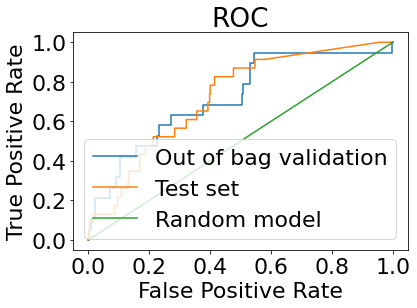

In [59]:
fpt, tpt, _ = roc_curve(ytrain, ytrain_score[:,1])
fpts, tpts, _ = roc_curve(ytest, ypred[:,1])
plt.plot(fpt, tpt)
plt.plot(fpts, tpts)
plt.plot([0,1],[0,1]) 
plt.legend(["Out of bag validation","Test set","Random model"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.rcParams.update({'font.size': 12});

Another relevant thing to the project is the feature importance. These are the most relevant features in the model:

In [60]:
importance = rf_ps1.feature_importances_
importance_list = []

for i in range(0,len(Xtrain.columns)):
    importance_list.append((Xtrain.columns[i], importance[i]))

importance_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [61]:
pd.set_option('display.max_columns', None)
importance_df.sort_values("Importance", ascending = False).transpose()

,0,39,193,134,59,78,21,85,47,17,1,57,139,121,191,19,194,198,37,180,141,28,41,51,132,192,183,190,5,42,144,27,84,181,52,77,172,58,50,182,199,103,43,153,152,67,48,187,68,131,31,44,60,123,184,83,118,179,40,72,239,2,217,45,53,188,49,171,119,23,108,211,232,218,238,209,225,4,165,122,79,64,136,117,201,197,130,221,196,125,200,185,11,25,203,56,124,61,230,65,24,111,186,162,12,138,18,22,8,9,219,231,63,32,178,10,71,113,30,38,3,170,189,210,46,161,62,102,202,222,13,73,110,70,33,145,129,133,195,101,104,214,128,120,174,74,36,140,176,34,163,112,204,81,16,98,208,76,223,6,82,212,234,105,7,29,66,80,75,143,177,116,216,158,224,93,164,237,159,150,205,26,14,92,109,126,169,15,233,20,142,54,127,35,151,213,228,173,229,55,215,235,220,236,227,226,69,91,207,115,146,147,148,149,137,154,155,156,157,160,135,166,167,168,114,206,175,107,106,100,99,97,96,95,94,90,89,88,87,86,240
Predictor,Intensity,Gov_Opp_19,Peo_Gov_13,Opp_Gov_14,Gov_Peo_19,Ins_Gov_18,Gov_Opp_01,Ins_Opp_05,Gov_Peo_07,Gov_Ins_17,Gov_Ins_01,Gov_Peo_17,Opp_Gov_19,Opp_Gov_01,Peo_Gov_11,Gov_Ins_19,Peo_Gov_14,Peo_Gov_18,Gov_Opp_17,Opp_Peo_20,Opp_Ins_01,Gov_Opp_08,Gov_Peo_01,Gov_Peo_11,Opp_Gov_12,Peo_Gov_12,Peo_Gov_03,Peo_Gov_10,Gov_Ins_05,Gov_Peo_02,Opp_Ins_04,Gov_Opp_07,Ins_Opp_04,Peo_Gov_01,Gov_Peo_12,Ins_Gov_17,Opp_Peo_12,Gov_Peo_18,Gov_Peo_10,Peo_Gov_02,Peo_Gov_19,Ins_Peo_03,Gov_Peo_03,Opp_Ins_13,Opp_Ins_12,Ins_Gov_07,Gov_Peo_08,Peo_Gov_07,Ins_Gov_08,Opp_Gov_11,Gov_Opp_11,Gov_Peo_04,Gov_Peo_20,Opp_Gov_03,Peo_Gov_04,Ins_Opp_03,Ins_Peo_18,Opp_Peo_19,Gov_Opp_20,Ins_Gov_12,Peo_Opp_19,Gov_Ins_02,Peo_Ins_17,Gov_Peo_05,Gov_Peo_13,Peo_Gov_08,Gov_Peo_09,Opp_Peo_11,Ins_Peo_19,Gov_Opp_03,Ins_Peo_08,Peo_Ins_11,Peo_Opp_12,Peo_Ins_18,Peo_Opp_18,Peo_Ins_09,Peo_Opp_05,Gov_Ins_04,Opp_Peo_05,Opp_Gov_02,Ins_Gov_19,Ins_Gov_04,Opp_Gov_16,Ins_Peo_17,Peo_Ins_01,Peo_Gov_17,Opp_Gov_10,Peo_Opp_01,Peo_Gov_16,Opp_Gov_05,Peo_Gov_20,Peo_Gov_05,Gov_Ins_11,Gov_Opp_05,Peo_Ins_03,Gov_Peo_16,Opp_Gov_04,Ins_Gov_01,Peo_Opp_10,Ins_Gov_05,Gov_Opp_04,Ins_Peo_11,Peo_Gov_06,Opp_Peo_02,Gov_Ins_12,Opp_Gov_18,Gov_Ins_18,Gov_Opp_02,Gov_Ins_08,Gov_Ins_09,Peo_Ins_19,Peo_Opp_11,Ins_Gov_03,Gov_Opp_12,Opp_Peo_18,Gov_Ins_10,Ins_Gov_11,Ins_Peo_13,Gov_Opp_10,Gov_Opp_18,Gov_Ins_03,Opp_Peo_10,Peo_Gov_09,Peo_Ins_10,Gov_Peo_06,Opp_Peo_01,Ins_Gov_02,Ins_Peo_02,Peo_Ins_02,Peo_Opp_02,Gov_Ins_13,Ins_Gov_13,Ins_Peo_10,Ins_Gov_10,Gov_Opp_13,Opp_Ins_05,Opp_Gov_09,Opp_Gov_13,Peo_Gov_15,Ins_Peo_01,Ins_Peo_04,Peo_Ins_14,Opp_Gov_08,Ins_Peo_20,Opp_Peo_14,Ins_Gov_14,Gov_Opp_16,Opp_Gov_20,Opp_Peo_16,Gov_Opp_14,Opp_Peo_03,Ins_Peo_12,Peo_Ins_04,Ins_Opp_01,Gov_Ins_16,Ins_Opp_18,Peo_Ins_08,Ins_Gov_16,Peo_Opp_03,Gov_Ins_06,Ins_Opp_02,Peo_Ins_12,Peo_Opp_14,Ins_Peo_05,Gov_Ins_07,Gov_Opp_09,Ins_Gov_06,Ins_Gov_20,Ins_Gov_15,Opp_Ins_03,Opp_Peo_17,Ins_Peo_16,Peo_Ins_16,Opp_Ins_18,Peo_Opp_04,Ins_Opp_13,Opp_Peo_04,Peo_Opp_17,Opp_Ins_19,Opp_Ins_10,Peo_Ins_05,Gov_Opp_06,Gov_Ins_14,Ins_Opp_12,Ins_Peo_09,Opp_Gov_06,Opp_Peo_09,Gov_Ins_15,Peo_Opp_13,Gov_Ins_20,Opp_Ins_02,Gov_Peo_14,Opp_Gov_07,Gov_Opp_15,Opp_Ins_11,Peo_Ins_13,Peo_Opp_08,Opp_Peo_13,Peo_Opp_09,Gov_Peo_15,Peo_Ins_15,Peo_Opp_15,Peo_Ins_20,Peo_Opp_16,Peo_Opp_07,Peo_Opp_06,Ins_Gov_09,Ins_Opp_11,Peo_Ins_07,Ins_Peo_15,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Gov_17,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_20,Opp_Gov_15,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Ins_Peo_14,Peo_Ins_06,Opp_Peo_15,Ins_Peo_07,Ins_Peo_06,Ins_Opp_20,Ins_Opp_19,Ins_Opp_17,Ins_Opp_16,Ins_Opp_15,Ins_Opp_14,Ins_Opp_10,Ins_Opp_09,Ins_Opp_08,Ins_Opp_07,Ins_Opp_06,Peo_Opp_20
Importance,0.0380543,0.0301999,0.02901,0.0232789,0.0229089,0.0215089,0.019487,0.0193899,0.0190058,0.0186366,0.0184815,0.0181597,0.0178777,0.0167385,0.0165195,0.0165092,0.0164949,0.0161434,0.0150189,0.0149723,0.0149605,0.0147975,0.0142526,0.0139573,0.0132956,0.0129159,0.0128917,0.0123803,0.0123624,0.0122898,0.0121674,0.012003,0.0119677,0.0117481,0.0115536,0.0114711,0.0108467,0.0106464,0.0105324,0.0104618,0.0102998,0.00982592,0.00955992,0.00954297,0.00947164,0.00945042,0.00908593,0.

Although *Intensity* did not have a p-value bellow 0.05 (it was 0.062, slighly bigger), it is the most relevant feature in the model. Due to the difference between means, this suggests that the variable is able to determine the escalation of the conflict.

Among the 5 predictors with higher importance, the CAMEO codes are:
- 19 (Fight): From government towards opposition and people. Suggesting once more scalation of the conflict and state represion. Same results as with the p-values. 
- 13 (Threaten): From people towards government. This suggests the escalation of the conflict and justifies the importance of *Gov_Peo_19* as an answer from the government. 
- 14 (Protest): From opposition towards government. This suggests again that opposition tends to get involved only by verbal conflict. 
- 18 (Assault): From insurgents towards government. Suggesting the dialogue between these sectors with fights and repression. Same results as in the p-values.

### 2.2.2. Training the end of a civil war predictor

In [62]:
cameo_counts_eo.sample(5)

,ISO3,Year_Month,Intensity,Gov_Ins_01,Gov_Ins_02,Gov_Ins_03,Gov_Ins_04,Gov_Ins_05,Gov_Ins_06,Gov_Ins_07,Gov_Ins_08,Gov_Ins_09,Gov_Ins_10,Gov_Ins_11,Gov_Ins_12,Gov_Ins_13,Gov_Ins_14,Gov_Ins_15,Gov_Ins_16,Gov_Ins_17,Gov_Ins_18,Gov_Ins_19,Gov_Ins_20,Gov_Opp_01,Gov_Opp_02,Gov_Opp_03,Gov_Opp_04,Gov_Opp_05,Gov_Opp_06,Gov_Opp_07,Gov_Opp_08,Gov_Opp_09,Gov_Opp_10,Gov_Opp_11,Gov_Opp_12,Gov_Opp_13,Gov_Opp_14,Gov_Opp_15,Gov_Opp_16,Gov_Opp_17,Gov_Opp_18,Gov_Opp_19,Gov_Opp_20,Gov_Peo_01,Gov_Peo_02,Gov_Peo_03,Gov_Peo_04,Gov_Peo_05,Gov_Peo_06,Gov_Peo_07,Gov_Peo_08,Gov_Peo_09,Gov_Peo_10,Gov_Peo_11,Gov_Peo_12,Gov_Peo_13,Gov_Peo_14,Gov_Peo_15,Gov_Peo_16,Gov_Peo_17,Gov_Peo_18,Gov_Peo_19,Gov_Peo_20,Ins_Gov_01,Ins_Gov_02,Ins_Gov_03,Ins_Gov_04,Ins_Gov_05,Ins_Gov_06,Ins_Gov_07,Ins_Gov_08,Ins_Gov_09,Ins_Gov_10,Ins_Gov_11,Ins_Gov_12,Ins_Gov_13,Ins_Gov_14,Ins_Gov_15,Ins_Gov_16,Ins_Gov_17,Ins_Gov_18,Ins_Gov_19,Ins_Gov_20,Ins_Opp_01,Ins_Opp_02,Ins_Opp_03,Ins_Opp_04,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_08,Ins_Opp_09,Ins_Opp_10,Ins_Opp_11,Ins_Opp_12,Ins_Opp_13,Ins_Opp_14,Ins_Opp_15,Ins_Opp_16,Ins_Opp_17,Ins_Opp_18,Ins_Opp_19,Ins_Opp_20,Ins_Peo_01,Ins_Peo_02,Ins_Peo_03,Ins_Peo_04,Ins_Peo_05,Ins_Peo_06,Ins_Peo_07,Ins_Peo_08,Ins_Peo_09,Ins_Peo_10,Ins_Peo_11,Ins_Peo_12,Ins_Peo_13,Ins_Peo_14,Ins_Peo_15,Ins_Peo_16,Ins_Peo_17,Ins_Peo_18,Ins_Peo_19,Ins_Peo_20,Opp_Gov_01,Opp_Gov_02,Opp_Gov_03,Opp_Gov_04,Opp_Gov_05,Opp_Gov_06,Opp_Gov_07,Opp_Gov_08,Opp_Gov_09,Opp_Gov_10,Opp_Gov_11,Opp_Gov_12,Opp_Gov_13,Opp_Gov_14,Opp_Gov_15,Opp_Gov_16,Opp_Gov_17,Opp_Gov_18,Opp_Gov_19,Opp_Gov_20,Opp_Ins_01,Opp_Ins_02,Opp_Ins_03,Opp_Ins_04,Opp_Ins_05,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Ins_10,Opp_Ins_11,Opp_Ins_12,Opp_Ins_13,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_18,Opp_Ins_19,Opp_Ins_20,Opp_Peo_01,Opp_Peo_02,Opp_Peo_03,Opp_Peo_04,Opp_Peo_05,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Opp_Peo_09,Opp_Peo_10,Opp_Peo_11,Opp_Peo_12,Opp_Peo_13,Opp_Peo_14,Opp_Peo_15,Opp_Peo_16,Opp_Peo_17,Opp_Peo_18,Opp_Peo_19,Opp_Peo_20,Peo_Gov_01,Peo_Gov_02,Peo_Gov_03,Peo_Gov_04,Peo_Gov_05,Peo_Gov_06,Peo_Gov_07,Peo_Gov_08,Peo_Gov_09,Peo_Gov_10,Peo_Gov_11,Peo_Gov_12,Peo_Gov_13,Peo_Gov_14,Peo_Gov_15,Peo_Gov_16,Peo_Gov_17,Peo_Gov_18,Peo_Gov_19,Peo_Gov_20,Peo_Ins_01,Peo_Ins_02,Peo_Ins_03,Peo_Ins_04,Peo_Ins_05,Peo_Ins_06,Peo_Ins_07,Peo_Ins_08,Peo_Ins_09,Peo_Ins_10,Peo_Ins_11,Peo_Ins_12,Peo_Ins_13,Peo_Ins_14,Peo_Ins_15,Peo_Ins_16,Peo_Ins_17,Peo_Ins_18,Peo_Ins_19,Peo_Ins_20,Peo_Opp_01,Peo_Opp_02,Peo_Opp_03,Peo_Opp_04,Peo_Opp_05,Peo_Opp_06,Peo_Opp_07,Peo_Opp_08,Peo_Opp_09,Peo_Opp_10,Peo_Opp_11,Peo_Opp_12,Peo_Opp_13,Peo_Opp_14,Peo_Opp_15,Peo_Opp_16,Peo_Opp_17,Peo_Opp_18,Peo_Opp_19,Peo_Opp_20,CW_plus1
2752,BDI,2003-07,-565.3,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
37328,SOM,1998-04,-139.8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [63]:
X = cameo_counts_eo.iloc[:,2:-1]
y = cameo_counts_eo.iloc[:,-1]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.6, random_state=1492)

In [64]:
rf_eo1 = RandomForestClassifier(random_state = 1492, n_estimators = 10000, oob_score = True,
                               criterion = "entropy", max_depth = 4);

In [65]:
cv_res = cross_val_score(rf_eo1, Xtrain, ytrain, scoring = "roc_auc", cv = 5)
cv_res

array([0.88240271, 0.64915254, 0.52372881, 0.61751412, 0.51440678])

In [66]:
np.mean(cv_res)

0.6374409934325618

In [67]:
rf_eo1.fit(Xtrain, ytrain)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=10000,
                       oob_score=True, random_state=1492)

In [68]:
ytrain_score = rf_eo1.oob_decision_function_

In [69]:
roc_auc_score(ytrain, ytrain_score[:,1])

0.5780569819878529

In [70]:
ypred = rf_eo1.predict_proba(Xtest)
roc_auc_score(ytest, ypred[:,1])

0.6555509167449466

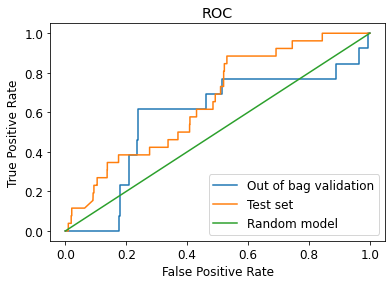

In [71]:
fpt, tpt, _ = roc_curve(ytrain, ytrain_score[:,1])
fpts, tpts, _ = roc_curve(ytest, ypred[:,1])
plt.plot(fpt, tpt)
plt.plot(fpts, tpts)
plt.plot([0,1],[0,1]) 
plt.legend(["Out of bag validation","Test set","Random model"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.rcParams.update({'font.size': 12});

In [72]:
importance = rf_eo1.feature_importances_
importance_list = []

for i in range(0,len(Xtrain.columns)):
    importance_list.append((Xtrain.columns[i], importance[i]))

importance_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [73]:
pd.set_option('display.max_columns', None)
importance_df.sort_values("Importance", ascending = False).transpose()

,59,78,0,57,198,79,181,44,42,184,51,19,118,12,18,191,31,119,48,41,17,1,134,43,212,182,204,104,126,70,194,205,199,201,53,192,50,61,183,193,121,189,71,47,63,186,178,11,46,52,68,45,101,8,4,16,58,188,64,190,185,217,37,21,2,49,113,10,38,120,3,32,203,218,231,5,39,211,65,131,162,73,108,132,125,25,187,124,122,110,111,102,9,24,138,62,202,56,72,196,221,219,60,28,130,13,23,22,103,210,238,117,76,74,200,171,77,170,55,222,123,161,112,158,197,213,6,30,174,109,66,69,141,223,80,142,234,20,239,75,33,214,180,139,163,151,88,195,240,232,67,36,224,164,145,140,40,98,116,230,133,136,7,160,128,107,216,14,54,208,105,81,228,206,168,96,95,209,207,94,93,97,92,149,215,229,82,237,236,235,83,233,84,227,91,226,225,85,86,87,89,90,220,115,99,173,143,169,167,166,165,144,146,159,147,157,156,154,153,152,148,172,137,100,175,106,114,150,15,127,26,27,129,29,35,135,179,34,177,176,155
Predictor,Gov_Peo_19,Ins_Gov_18,Intensity,Gov_Peo_17,Peo_Gov_18,Ins_Gov_19,Peo_Gov_01,Gov_Peo_04,Gov_Peo_02,Peo_Gov_04,Gov_Peo_11,Gov_Ins_19,Ins_Peo_18,Gov_Ins_12,Gov_Ins_18,Peo_Gov_11,Gov_Opp_11,Ins_Peo_19,Gov_Peo_08,Gov_Peo_01,Gov_Ins_17,Gov_Ins_01,Opp_Gov_14,Gov_Peo_03,Peo_Ins_12,Peo_Gov_02,Peo_Ins_04,Ins_Peo_04,Opp_Gov_06,Ins_Gov_10,Peo_Gov_14,Peo_Ins_05,Peo_Gov_19,Peo_Ins_01,Gov_Peo_13,Peo_Gov_12,Gov_Peo_10,Ins_Gov_01,Peo_Gov_03,Peo_Gov_13,Opp_Gov_01,Peo_Gov_09,Ins_Gov_11,Gov_Peo_07,Ins_Gov_03,Peo_Gov_06,Opp_Peo_18,Gov_Ins_11,Gov_Peo_06,Gov_Peo_12,Ins_Gov_08,Gov_Peo_05,Ins_Peo_01,Gov_Ins_08,Gov_Ins_04,Gov_Ins_16,Gov_Peo_18,Peo_Gov_08,Ins_Gov_04,Peo_Gov_10,Peo_Gov_05,Peo_Ins_17,Gov_Opp_17,Gov_Opp_01,Gov_Ins_02,Gov_Peo_09,Ins_Peo_13,Gov_Ins_10,Gov_Opp_18,Ins_Peo_20,Gov_Ins_03,Gov_Opp_12,Peo_Ins_03,Peo_Ins_18,Peo_Opp_11,Gov_Ins_05,Gov_Opp_19,Peo_Ins_11,Ins_Gov_05,Opp_Gov_11,Opp_Peo_02,Ins_Gov_13,Ins_Peo_08,Opp_Gov_12,Opp_Gov_05,Gov_Opp_05,Peo_Gov_07,Opp_Gov_04,Opp_Gov_02,Ins_Peo_10,Ins_Peo_11,Ins_Peo_02,Gov_Ins_09,Gov_Opp_04,Opp_Gov_18,Ins_Gov_02,Peo_Ins_02,Gov_Peo_16,Ins_Gov_12,Peo_Gov_16,Peo_Opp_01,Peo_Ins_19,Gov_Peo_20,Gov_Opp_08,Opp_Gov_10,Gov_Ins_13,Gov_Opp_03,Gov_Opp_02,Ins_Peo_03,Peo_Ins_10,Peo_Opp_18,Ins_Peo_17,Ins_Gov_16,Ins_Gov_14,Peo_Gov_20,Opp_Peo_11,Ins_Gov_17,Opp_Peo_10,Gov_Peo_15,Peo_Opp_02,Opp_Gov_03,Opp_Peo_01,Ins_Peo_12,Opp_Ins_18,Peo_Gov_17,Peo_Ins_13,Gov_Ins_06,Gov_Opp_10,Opp_Peo_14,Ins_Peo_09,Ins_Gov_06,Ins_Gov_09,Opp_Ins_01,Peo_Opp_03,Ins_Gov_20,Opp_Ins_02,Peo_Opp_14,Gov_Ins_20,Peo_Opp_19,Ins_Gov_15,Gov_Opp_13,Peo_Ins_14,Opp_Peo_20,Opp_Gov_19,Opp_Peo_03,Opp_Ins_11,Ins_Opp_08,Peo_Gov_15,Peo_Opp_20,Peo_Opp_12,Ins_Gov_07,Gov_Opp_16,Peo_Opp_04,Opp_Peo_04,Opp_Ins_05,Opp_Gov_20,Gov_Opp_20,Ins_Opp_18,Ins_Peo_16,Peo_Opp_10,Opp_Gov_13,Opp_Gov_16,Gov_Ins_07,Opp_Ins_20,Opp_Gov_08,Ins_Peo_07,Peo_Ins_16,Gov_Ins_14,Gov_Peo_14,Peo_Ins_08,Ins_Peo_05,Ins_Opp_01,Peo_Opp_08,Peo_Ins_06,Opp_Peo_08,Ins_Opp_16,Ins_Opp_15,Peo_Ins_09,Peo_Ins_07,Ins_Opp_14,Ins_Opp_13,Ins_Opp_17,Ins_Opp_12,Opp_Ins_09,Peo_Ins_15,Peo_Opp_09,Ins_Opp_02,Peo_Opp_17,Peo_Opp_16,Peo_Opp_15,Ins_Opp_03,Peo_Opp_13,Ins_Opp_04,Peo_Opp_07,Ins_Opp_11,Peo_Opp_06,Peo_Opp_05,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_09,Ins_Opp_10,Peo_Ins_20,Ins_Peo_15,Ins_Opp_19,Opp_Peo_13,Opp_Ins_03,Opp_Peo_09,Opp_Peo_07,Opp_Peo_06,Opp_Peo_05,Opp_Ins_04,Opp_Ins_06,Opp_Ins_19,Opp_Ins_07,Opp_Ins_17,Opp_Ins_16,Opp_Ins_14,Opp_Ins_13,Opp_Ins_12,Opp_Ins_08,Opp_Peo_12,Opp_Gov_17,Ins_Opp_20,Opp_Peo_15,Ins_Peo_06,Ins_Peo_14,Opp_Ins_10,Gov_Ins_15,Opp_Gov_07,Gov_Opp_06,Gov_Opp_07,Opp_Gov_09,Gov_Opp_09,Gov_Opp_15,Opp_Gov_15,Opp_Peo_19,Gov_Opp_14,Opp_Peo_17,Opp_Peo_16,Opp_Ins_15
Importance,0.0418124,0.039061,0.0386871,0.0316182,0.0304464,0.0279114,0.027338,0.024794,0.0242956,0.023654,0.0236458,0.0228994,0.0218704,0.0213354,0.0182218,0.0176025,0.0172632,0.0172372,0.0171545,0.0162746,0.0145603,0.0142332,0.014178,0.0136887,0.0131893,0.0130064,0.0129545,0.0128661,0.0125148,0.0120292,0.0119325,0.0112567,0.0112173,0.0109278,0.0108153,0.0107635,0.00977312,0.00949618,0.00936671,0.00936499,0.00869705,0.00868368,0.00815671,0.00803658,0.0076837,0.00759124,0.00736007

Once again, the *Intensity* predictor appears as the most relevant one. However, the p-value for this case was of 0.004, which is bellow the 0.05 threshold. The 5 most important predictors have the following CAMEO codes:
- 18 (Assault) and 19 (Fight), suggesting that the amount of assaults and fights are different during conflict and at the end of the civil war. This is probably due to the relaxation of the conflict. 
- 17 (Coerce) from government towards people and 11 (Disapprove) from government towards opposition. Suggesing relaxation of the conflict, or that the government is in a very low possition. 
- 01 (Make public statement) from people to government, suggesting criticism and discredit.
- 11 (Disapprove) suggesting critism and discredit. 

These all reflect the relaxation of the conflict and puts the government in a very tight place where it is not able to negociate or impose over the other sectors. 

## 3. Predictions with unseen data
To see the models working, last available data from 2020 will be used. The latest data is from April 2020, meaning that the pandemic was going on and that events are heavily affected by this global event so it will not be used for because of that. Instead, data from January will be used to predict the outcome in February. To retrieve the 2020 data:

In [74]:
year_2019= cw.iso3country("events.zip",2020)
year_2019.sample(5)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
73344,India,IND,2020-02,010,0.0,0,0,1,0,0,0,0,0,0,0,0,0
25369,India,IND,2020-01,010,0.0,1,0,0,0,0,0,0,0,0,0,0,0
144026,Australia,AUS,2020-03,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
96215,Kenya,KEN,2020-02,193,-10.0,0,0,1,0,0,0,0,0,0,0,0,0
143497,Australia,AUS,2020-03,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0


And now, the same aggregation process will be applied:

In [75]:
# Generating model
cameo_counts_2019 = year_2019[["ISO3","Year_Month","Intensity"]]

In [76]:
# Selecting just the first two numbers of the CAMEO code
cameo_counts_2019["CAMEO"] = year_2019["CAMEO"].apply(lambda x: x[:2])

In [77]:
# Getting values in the right column
cols = year_2019.columns[5:]
for col in cols:
    cameo_counts_2019[col] = year_2019[col]*cameo_counts_2019["CAMEO"]
    cameo_counts_2019[col] = cameo_counts_2019[col].apply(cw.cleaning_cameo) # Custom function

In [78]:
# Filling missing values
cameo_counts_2019 = cameo_counts_2019.fillna(0)

In [79]:
# Adding dummy variables
cameo_counts_2019 = cameo_counts_2019.drop(["CAMEO"], axis=1)
cameo = ["01","02","03","04","05","06","07","08","09","10",
         "11","12","13","14","15","16","17","18","19","20"]
for col in cols:
    for code in cameo:
        col_name = col+'_'+code
        cameo_counts_2019[col_name] = (cameo_counts_2019[col] == code).astype("int64")

In [80]:
# Removing irrelevant columns
cameo_counts_2019 = cameo_counts_2019.drop(cols, axis = 1)

In [81]:
# Aggregating
cameo_counts_2019 = cameo_counts_2019.groupby(["ISO3","Year_Month"]).sum().reset_index()

In [82]:
Xpred_2019 = cameo_counts_2019[cameo_counts_2019["Year_Month"]=="2020-01"]

Finally, the predictions:

In [83]:
Xpred_2019["Prediction"] = (rf_ps1.predict_proba(Xpred_2019.iloc[:,2:]))[:,1]

In [84]:
Xpred_2019[["ISO3","Prediction"]].sort_values("Prediction", ascending = False).head(5)

,ISO3,Prediction
247,IND,0.149640
444,PHL,0.018707
259,IRQ,0.015064
309,LBN,0.012463
224,HKG,0.003618


The model was used to predict the chances of a civil war starting in Feabruary 2020. The results  for the top 5 probabilities are shown above. Possible events that the model could have predicted are:
- India: In February 2020 riots in Delhi took place and ended up with 53 deaths. These were caused by Hindu mobs attacking Muslims. 
- Philippines: Some opposition senators were indicted with “conspiracy to commit sedition”. A former chairman of the Communist Party of the Philippines was arrested and a former official was shot dead. 
- Iraq: An anti-government protest camp was raided and 8 people were shot dead. 
- Lebanon: The political situation is very critical, with a new cabinet formed after months without one and with the October Revolution resuming. 
- Hong Kong: The  Anti-Extradition Law Amendment Bill Movemen are ongoing in January. However it was paused on february due to the pandemic. However, the model was not trained to determine this. 